Using a ACO to learn mywayhome (test where I limit it to 4 directions)

Import everything

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import math
from torch.utils.tensorboard import SummaryWriter
from vizdoom import * #Import all of vizdoom
import time #To make the program sleep (wait), so we can actually see what's happening
from gymnasium import Env #Import OpenAI Gym's Env class
from gymnasium.spaces import Discrete, Box #Import OpenAI Gym's Discrete and Box spaces
import cv2 #OpenCV for image processing, used for modifying the DOOM environment to make it run faster 
from stable_baselines3.common.callbacks import BaseCallback #Import the BaseCallback class from stable_baselines3 to learn from the environment
from stable_baselines3.common import env_checker #Import the env_checker class from stable_baselines3 to check the environment
import os #To create directories for saving models
import sys #To change the path so we can import the pathfinder module
import matplotlib.pyplot as plt
from collections import deque

original_sys_path = sys.path.copy() #Come back to this path later after we navigate to the parent directory
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))  #Add the parent directory to the path so we can import the pathfinder module
from pathfinder import doomfinder, create_new_best_generation_directory, gamefinder #Import functions from the pathfinder module
sys.path = original_sys_path #Set the path back to the original path

Create a grid with map boundries defined 

In [ ]:
#Map extreme vertices
MIN_X, MAX_X = 160, 1120
MIN_Y, MAX_Y = -704, 128

#Grid dimensions, the map size is actually 960x832
GRID_WIDTH = 960  #1 unit per cell
GRID_HEIGHT = 832  #1 unit per cell

grid_size = (GRID_HEIGHT, GRID_WIDTH)

#Extracted vertices (x, y) coordinates
vertices = [
    (160.000, -256.000), (160.000, -96.000), (320.000, -96.000), (320.000, -144.000),
    (320.000, -256.000), (320.000, -208.000), (544.000, -256.000), (496.000, -256.000),
    (544.000, -96.000), (544.000, -144.000), (384.000, -96.000), (432.000, -96.000),
    (384.000, -256.000), (384.000, -208.000), (544.000, -32.000), (496.000, -32.000),
    (544.000, 128.000), (544.000, 80.000), (384.000, 128.000), (384.000, -32.000),
    (608.000, -256.000), (608.000, -208.000), (768.000, -256.000), (768.000, -96.000),
    (608.000, -96.000), (656.000, -96.000), (608.000, -32.000), (608.000, 16.000),
    (768.000, -32.000), (720.000, -32.000), (768.000, 128.000), (768.000, 80.000),
    (608.000, 128.000), (384.000, -384.000), (432.000, -384.000), (384.000, -544.000),
    (544.000, -544.000), (496.000, -544.000), (544.000, -384.000), (960.000, -32.000),
    (960.000, 16.000), (1120.000, -32.000), (1072.000, -32.000), (1120.000, 128.000),
    (960.000, 128.000), (960.000, -256.000), (960.000, -96.000), (1120.000, -256.000),
    (1088.000, -256.000), (1120.000, -96.000), (1008.000, -96.000), (992.000, -416.000),
    (992.000, -256.000), (1088.000, -416.000), (1072.000, -96.000), (1008.000, -32.000),
    (384.000, -144.000), (848.000, 16.000), (768.000, 16.000), (960.000, 80.000),
    (576.000, 16.000), (544.000, 16.000), (608.000, 80.000), (720.000, -96.000),
    (656.000, -32.000), (496.000, -96.000), (432.000, -32.000), (432.000, -256.000),
    (496.000, -384.000), (432.000, -704.000), (432.000, -544.000), (496.000, -640.000),
    (576.000, -640.000), (576.000, -704.000), (544.000, -208.000), (608.000, -144.000)
]

#Extracted linedefs as pairs of vertex indices
linedefs = [
    (0, 1), (1, 2), (2, 3), (4, 0), (5, 4), (6, 7), (8, 9), (10, 11),
    (12, 13), (14, 15), (16, 17), (18, 16), (19, 18), (20, 21), (22, 20),
    (23, 22), (24, 25), (26, 27), (28, 29), (30, 31), (32, 30), (33, 34),
    (35, 33), (36, 37), (38, 36), (39, 40), (41, 42), (43, 41), (44, 43),
    (45, 46), (47, 48), (49, 47), (46, 50), (51, 52), (53, 51), (48, 53),
    (48, 52), (13, 5), (52, 45), (54, 49), (42, 54), (42, 55), (50, 55),
    (50, 54), (13, 56), (55, 39), (57, 58), (31, 58), (31, 59), (40, 59),
    (40, 57), (58, 28), (59, 44), (60, 61), (17, 61), (17, 62), (27, 62),
    (27, 60), (61, 14), (62, 32), (29, 63), (29, 64), (25, 64), (25, 63),
    (56, 10), (63, 23), (64, 26), (15, 65), (15, 66), (11, 66), (11, 65),
    (3, 5), (65, 8), (66, 19), (67, 12), (34, 67), (34, 68), (7, 68),
    (7, 67), (3, 56), (68, 38), (69, 70), (37, 70), (37, 71), (71, 72),
    (72, 73), (73, 69), (70, 35), (21, 74), (9, 74), (9, 75), (21, 75),
    (75, 24), (74, 6)
]

#Initialize the grid with -1 (outside cells)
starter_grid = np.full(grid_size, -1, dtype=np.float64)

def coord_to_grid(x, y):
    #Convert coordinates to grid indices
    if x < MIN_X or x > MAX_X or y < MIN_Y or y > MAX_Y:
        raise ValueError(f"Coordinates ({x}, {y}) are out of bounds!")
    
    norm_x = (x - MIN_X) / (MAX_X - MIN_X)
    norm_y = (y - MIN_Y) / (MAX_Y - MIN_Y)
    
    grid_x = int(norm_x * (GRID_WIDTH - 1))
    grid_y = int(norm_y * (GRID_HEIGHT - 1))

    return (grid_x, grid_y)

def draw_line(starter_grid, start, end):
    x1, y1 = coord_to_grid(start[0], start[1])
    x2, y2 = coord_to_grid(end[0], end[1])
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1
    err = dx - dy

    while True:
        starter_grid[y1, x1] = 0  # Mark cell as 0 (inside the linedef)
        if x1 == x2 and y1 == y2:
            break
        e2 = err * 2
        if e2 > -dy:
            err -= dy
            x1 += sx
        if e2 < dx:
            err += dx
            y1 += sy


#Draw all lines on the grid
for linedef in linedefs:
    start_vertex = vertices[linedef[0]]
    end_vertex = vertices[linedef[1]]
    draw_line(starter_grid, start_vertex, end_vertex)


#Function to print the grid
def print_grid(starter_grid):
    for row in starter_grid:
        print(' '.join(f'{cell:3}' for cell in row))

#Print the grid to check the result
print_grid(starter_grid)


def flood_fill(starter_grid, start_x, start_y):
    if starter_grid[start_y, start_x] != -1:  # Start only if the cell is not filled or part of the boundary
        return

    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    queue = deque([(start_x, start_y)])

    while queue:
        x, y = queue.popleft()

        if starter_grid[y, x] != -1:  # If already visited or is a boundary, skip
            continue

        starter_grid[y, x] = 0  # Fill the cell

        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < GRID_WIDTH and 0 <= ny < GRID_HEIGHT and starter_grid[ny, nx] == -1:
                queue.append((nx, ny))


insides = [(385, -144), (319, -208), (321, -207), (545, -207), (654, -97), (496, -641), (432, -543), (464, -320), (461, 49), (464, -68),
           (578, 48), (672, -64), (832, 64), (672, 64), (1056, -288), (1024, -160), (1056, -65), (1024, 32)]

for vertex in insides:
    x, y = coord_to_grid(vertex[0], vertex[1])
    flood_fill(starter_grid, x, y)
       

#Plot vertices
plt.figure(figsize=(10, 8))
plt.scatter(*zip(*[coord_to_grid(v[0], v[1]) for v in vertices]), c='blue', label='Vertices')

#Plot lines
for linedef in linedefs:
    start_vertex = vertices[linedef[0]]
    end_vertex = vertices[linedef[1]]
    start_grid = coord_to_grid(start_vertex[0], start_vertex[1])
    end_grid = coord_to_grid(end_vertex[0], end_vertex[1])
    plt.plot([start_grid[0], end_grid[0]], [start_grid[1], end_grid[1]], c='green')

#Create a heatmap to visualize the grid
plt.imshow(starter_grid, cmap='hot', interpolation='nearest')
plt.colorbar(label='Cell Values')
plt.title('Heatmap of Grid with Vertices and Lines')
plt.legend()
plt.show()

def get_starting_grid():
    starter_grid = np.full(grid_size, -1, dtype=np.float64)
    for linedef in linedefs:
        start_vertex = vertices[linedef[0]]
        end_vertex = vertices[linedef[1]]
        draw_line(starter_grid, start_vertex, end_vertex)
    for vertex in insides:
        x, y = coord_to_grid(vertex[0], vertex[1])
        flood_fill(starter_grid, x, y)
    return starter_grid

Define enviornment (for mywayhome)

In [3]:
#Note we are using are representing the map as a 960x832 grid

#Map extreme verticies
MIN_X, MAX_X = 160, 1120
MIN_Y, MAX_Y = -704, 128

#Grid dimensions, the map size is actually 960x832 but this allows us some leeway if we get close to the edge
GRID_WIDTH = 960 #1 unit per cell
GRID_HEIGHT = 832 #1 units per cell

starter_grid = get_starting_grid()

class mywayhome_VZG(Env): #Used for mywayhome config
    def __init__(self, config_path, render=False, grid_size=(GRID_HEIGHT, GRID_WIDTH), pheromone_evaporation_rate=0.001, pheromone_map = None, frameskip = 1): #Constructor
        #Args:
            #config_path (str): The path to the configuration file
            #render (bool): Whether to render the environment or not, false by default
            #grid_size (tuple): The size of the grid (x, y) for the environment
            #pheromone_evaporation_rate (float): The rate at which pheromones evaporate over time
            #pheromone_map (np.array): Optional pre-filled pheromone map, if not provided, it will be initialized with low pheromone levels
            #frameskip (int): The number of frames to skip between actions

        super(mywayhome_VZG, self).__init__() #Inherit from Env class

        #Setup game environment
        self.game = vizdoom.DoomGame() #Create a DoomGame object
        self.game.set_doom_game_path(gamefinder('DOOM2.WAD')) #Set the path to the game
        self.game.load_config(config_path) #Load the configuration file from file path
        self.game.set_window_visible(render) #Set window visibility based on render argument
        self.game.init() #Initialize the game
        self.frameskip = frameskip #Set the frameskip
        
        #Setup action and observation space
        self.observation_space = Box(low=0, high=255, shape=(100, 160, 1), dtype=np.uint8) #Observation space, 100x160x1 image, not needed for pathfinding just used for compatibility with stable_baselines3
        self.observation = np.zeros(self.observation_space.shape) #Observation is a blank image
        self.action_space = Discrete(4) #Action space, 4 actions (move forward, move left, move right, move backwards)

        #Grid dimensions and pheromone setup
        self.grid_size = grid_size #Set the grid size as specified 
        if pheromone_map is not None:
            self.pheromone_map = pheromone_map #Use the provided pheromone map if available
        else: #If no pheromone map is provided, initialize a new one
            self.pheromone_map = starter_grid  #Start with adjustable pheromone levels across the gri
        self.pheromone_evaporation_rate = pheromone_evaporation_rate  #Controls how fast pheromones decay over time

        #Get game variables
        game_variables = self.game.get_state().game_variables
        xpos, ypos, angle, velocity_x, velocity_y = game_variables #Unpack the game variables
        
        self.xpos = xpos #X position of the player
        self.ypos = ypos #Y position of the player
        self.angle = angle #Angle of the player 
        self.velocity_x = velocity_x #X velocity of the player
        self.velocity_y = velocity_y #Y velocity of the player

    def coord_to_grid(self, x, y): #Convert coordinates to grid indices
        #Args:
            #x (int): X coordinate to convert
            #y (int): Y coordinate to convert
        #Returns:
            #grid_x, grid_y (tuple): The grid indices corresponding to the coordinates
        #Raises:
            #ValueError: If the coordinates are out of bounds

        #Ensure coordinates are within world bounds
        #if x < MIN_X or x > MAX_X or y < MIN_Y or y > MAX_Y:
        #    raise ValueError(f"Coordinates ({x}, {y}) are out of bounds!")
        
        #Normalize coordinates to range [0, 1]
        norm_x = (x - MIN_X) / (MAX_X - MIN_X)
        norm_y = (y - MIN_Y) / (MAX_Y - MIN_Y)
        
        #print(f"norm_x = {norm_x}, norm_y = {norm_y}") #Debug print

        #Scale to grid dimensions and floor the values to ensure integers
        grid_x = int(norm_x * (GRID_WIDTH - 1))
        grid_y = int(norm_y * (GRID_HEIGHT - 1))

        #print(f"grid_x = {grid_x}, grid_y = {grid_y}") #Debug print

        return (grid_x, grid_y)

    def step(self, action, limit = 1000): #Take a step in the environment 
        #Args:
            #action (int): The action to take
            #limit (int): Unimplemented "limit" for the episode, most likely will be a time limit
        #Returns:
            #observation (np.array): The screen buffer of the environment
            #reward (float): The reward for the action taken
            #terminated (bool) Whether the episode is finished or not (by reaching the goal)
            #truncated (bool): Whether the episode has reached some terminal state without reaching the goal (ie: running out of time)
            #info (dict): Additional information about the environment

        #print(f"xpos = {self.xpos}, ypos = {self.ypos}, angle = {self.angle}") #Debug print
        #time.sleep(1) #DEBUG -----------------------------------

        #Specify actions and take a step
        actions = np.identity(4) #Create an identity matrix with 4 rows (4 actions), TURN_LEFT, TURN_RIGHT, MOVE_FOWARD, MOVE_LEFT, MOVE_RIGHT, MOVE_BACKWARD, these are the actions we can take in the environment

        self.game.make_action(actions[action], self.frameskip) #Take an action in the action space, second parameter is frame skip (how many frames we take an action for)
        truncated = False #Not implemented yet, so set to False. The idea is that if step passes some sort of limit, like a time limit, then the episode is truncated.
        info = {"xpos": self.xpos, "ypos": self.ypos, "angle": self.angle, "angle": self.angle, "velocity_x": self.velocity_x, "velocity_y": self.velocity_y} #Initialize info with current position and angle
        reward = 0 #Initialize reward to 0

        if self.game.get_state(): #If the game is not finished
            #observation = self.game.get_state().screen_buffer #Get the screen buffer (not needed for pathfinding)
            #observation = self.greyscale(observation) #Convert the image to greyscale
            
            xpos, ypos, angle, velocity_x, velocity_y = self.game.get_state().game_variables #Get the game variables
            self.xpos = xpos #Update the x position
            self.ypos = ypos #Update the y position
            self.angle = angle #Update the angle
            self.velocity_x = velocity_x #Update the x velocity
            self.velocity_y = velocity_y #Update the y velocity

            info = {"xpos": self.xpos, "ypos": self.ypos, "angle": self.angle, "velocity_x": self.velocity_x, "velocity_y": self.velocity_y} #Add position, angle and velocity info to the info dictionary

        #Update pheromones based on movement feedback
            #If this isnt a wall, add pheromones
            #self.pheromone_map[grid_y, grid_x] += 0.1 #Deposit pheromones
            #self.pheromone_map[self.pheromone_map != -1] *= (1 - self.pheromone_evaporation_rate)  #Simulate evaporation, except on walls
            
        terminated = self.game.is_episode_finished() #Check if the episode is finished
        observation = np.zeros(self.observation_space.shape) #Return a blank screen

        return observation, reward, terminated, truncated, info

    def reset(self): #Reset the environment when we start a new game
        #Args:
            #seed (int): The seed for the random number generator
        #Returns:
            #(observation, info) (tuple)
                #observation (np.array): The screen buffer of the environment
                #info (dict): Additional information about the environment
                
        self.game.new_episode() #Start a new episode
        game_variables = self.game.get_state().game_variables  #Get the game variables   
        self.xpos, self.ypos, self.angle, self.velocity_x, self.velocity_y = game_variables  #Unpack the game variables, set agent to its random starting position 

        state = self.game.get_state().screen_buffer
        observation = self.greyscale(state)  #Convert the initial screen state to greyscale
        info = {"xpos": self.xpos, "ypos": self.ypos, "angle": self.angle, "velocity_x": self.velocity_x, "velocity_y": self.velocity_y} #Add position, angle and velocity info to the info dictionary

        return observation, info  #Return the observation and any additional info

    def greyscale(self, observation): #Convert the environment image to greyscale and resize it
        #Args:
            #observation (np.array): The image of the environment (the current game frame)
        #Returns:
            #grey_return (np.array): The resized greyscale image of the environment
        
        grey = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY) #Convert the image to greyscale
        resize = cv2.resize(grey, (160, 100), interpolation=cv2.INTER_CUBIC) #Resize the image to 160x100 (frame size)
        state = np.reshape(resize, (100, 160, 1)) #Reshape to 100x160x1 for compatibility with neural networks
        
        return state

    def render(self, render_in_greyscale=False): #Render the environment for a frame
        #Args:
            #render_in_greyscale (bool): Whether to render the environment in greyscale or not
        
        if self.game.get_state() and render_in_greyscale:  #Only render if there's a valid game state
            observation = self.game.get_state().screen_buffer
            greyscale_obs = self.greyscale(observation)  #Convert the observation to greyscale
            cv2.imshow("VizDoom Environment", greyscale_obs.squeeze())  #Remove extra dimension and display
            cv2.waitKey(1)  #Wait 1ms between frames to allow for rendering
        elif self.game.get_state():  #Only render if there's a valid game state
            observation = self.game.get_state().screen_buffer
            cv2.imshow("VizDoom Environment", observation.squeeze())  #Render the environment without greyscale
            cv2.waitKey(1)  #Wait 1ms between frames to allow for rendering
        else:
            print("No game state to render.")

    def get_state(self): #Get the current state of the environment
        #Returns:
            #state (np.array): The current state of the environment
        return self.game.get_state()

    def get_agent_position(self): #Get the current position of the agent (tuple of x, y coordinates)
        #Returns:
            #(xpos, ypos) (tuple): The current position of the agent

        return (self.xpos, self.ypos)

    def close(self): #Close the environment when done
        self.game.close()  #Terminate the game

Define Plotting, Saving, and Finding Pheromone Maps

In [4]:
import matplotlib.colors as mcolors

def plot_pheromone_grid(pheromone_grid, title, log_dir, iteration, save_image):
    #Create a custom colormap
    cmap = plt.cm.hot
    cmap = cmap.copy()
    cmap.set_bad(color='blue') #Set color for walls (-1) to black

    #Mask the grid to handle walls (-1)
    masked_grid = np.ma.masked_where(pheromone_grid == -1, pheromone_grid)

    plt.imshow(masked_grid, cmap=cmap, interpolation='nearest')
    plt.title(title)
    plt.colorbar(label="Pheromone Intensity")
    if save_image:
        image_path = os.path.join(log_dir, f"pheromone_grid_iteration_{iteration}.png")
        plt.savefig(image_path)
        print(f"Pheromone grid image saved to {image_path}")
    plt.show()


def create_run_directory(base_dir="aco_runs/vizdoom_aco_mywayhome"): #Create a new run directory for the ACO algorithm
    os.makedirs(base_dir, exist_ok=True)
    existing_runs = [int(d.split('_')[-1]) for d in os.listdir(base_dir) if d.split('_')[-1].isdigit()]
    run_number = max(existing_runs, default=0) + 1
    run_dir = os.path.join(base_dir, f"run_{run_number}")
    os.makedirs(run_dir, exist_ok=True)
    #Create saved maps directory within the run directory
    maps_dir = os.path.join(run_dir, "saved_maps")
    os.makedirs(maps_dir, exist_ok=True)
    #Create log directory within the run directory
    log_dir = os.path.join(run_dir, "log")
    os.makedirs(log_dir, exist_ok=True)
    return run_dir, log_dir, maps_dir

def save_pheromone_grid(pheromone_grid, maps_dir, iteration):
    filename = os.path.join(maps_dir, f"pheromone_grid_iteration_{iteration}.npy")
    np.save(filename, pheromone_grid)
    #print(f"Pheromone grid saved to {filename}")

def load_pheromone_grid(run_dir="aco_runs/vizdoom_aco_mywayhome", run_number=0, filename="pheromone_grid.npy"):
    run_dir = os.path.join(run_dir, f"run_{run_number}/saved_maps")
    filepath = os.path.join(run_dir, filename)
    #print(filepath) #Print the path
    if os.path.exists(filepath):
        pheromone_grid = np.load(filepath)
        #print(f"Pheromone grid loaded from {filepath}")
        return pheromone_grid
    else:
        #print(f"No saved pheromone grid found at {filepath}")
        return None

Define Training

In [5]:
def aco_training(env, num_ants=10, iterations=50, alpha=0.6, beta=0.4, pheromone_deposit=2.0, unsuccessful_deposit=0.1, run_dir="aco_runs/vizdoom_aco_mywayhome", log_dir = "aco_runs/vizdoom_aco_mywayhome/run_x/log", maps_dir = "aco_runs/vizdoom_aco_mywayhome/run_x/saved_maps", distance_weight = 0.7, time_weight = 0.3, save_rate = 20, log_image_rate = 5): #Train the ACO algorithm in the ViZDoom environment
    """
    Train a bot to pathfind in the ViZDoom environment using ACO.
    
    Args:
        env (Env): The ViZDoom environment.
        num_ants (int): Number of ants (pathfinding agents) per iteration.
        iterations (int): Total iterations for ACO.
        alpha (float): Importance of pheromones.
        beta (float): Importance of heuristic (distance to goal).
        pheromone_deposit (float): Amount of pheromone deposited on successful paths.
        unsuccessful_deposit (float): Amount of pheromone deposited on unsuccessful paths.
        run_dir (str): Directory to save the ACO run data.
        log_dir (str): Directory to save logs and images.
        maps_dir (str): Directory to save pheromone maps.
        distance_weight (float): Weight for distance factor in pheromone update.
        time_weight (float): Weight for time factor in pheromone update.   
        save_rate (int): Rate at which to log sucess counts.
        log_image_rate (int): Rate at which to log pheromone grid images.
        """
    #Initialize pheromone grid
    pheromone_grid = env.pheromone_map
    
    frameskip = env.frameskip #Get the frameskip from the environment

    #Normalize alpha and beta to ensure they add up to 1
    total_weight = alpha + beta
    alpha /= total_weight
    beta /= total_weight

    #Generate list of goal positions
    #GOAL_POSITIONS = [env.coord_to_grid(x, y) for x in range(1008, 1072) for y in range(-324, -315)] 

    GOAL_POSITION = (1045, -316) #We simplify from a list of goal positions to one goal position because 
    #having a list of goal positions causes the agent to get stuck in a loop where it keeps going back and forth 
    #between the goal positions different equal minimum distances, which weakens the hueristic function, this 
    #position will always trigger the end of the episode

    #Heuristic function: inverse distance to the goal
    def heuristic(x, y):
        gx, gy = GOAL_POSITION
        distance = np.sqrt((gx - x) ** 2 + (gy - y) ** 2)
        return 1.0 / (distance + 1e-6)

    #Simulate movement locally without stepping the game, this is not 100% accurate but it's a good approximation
    def simulate_move(x, y, angle, velocity_x, velocity_y, move):

        friction = 0.90625  #Doom's friction factor
        step_size = env.frameskip  #Approximate movement step size
        angle_rad = np.deg2rad(angle)  #Convert angle to radians

        for step in range(step_size):
            if move == 0:  #MOVE_FORWARD
                velocity_x += np.cos(angle_rad)
                velocity_y += np.sin(angle_rad)
            elif move == 1:  #MOVE_LEFT
                velocity_x -= np.sin(angle_rad)
                velocity_y += np.cos(angle_rad)
            elif move == 2:  #MOVE_RIGHT
                velocity_x += np.sin(angle_rad)
                velocity_y -= np.cos(angle_rad)
            elif move == 3:  #MOVE_BACKWARD
                velocity_x -= np.cos(angle_rad)
                velocity_y -= np.sin(angle_rad)

            #Apply friction to velocities
            velocity_x *= friction
            velocity_y *= friction

            #Update positions based on the updated velocities
            x += velocity_x
            y += velocity_y

            x = np.clip(x, MIN_X+1, MAX_X-1)  #We might have gone out of bounds, so clip the x position
            y = np.clip(y, MIN_Y+1, MAX_Y-1)  #We might have gone out of bounds, so clip the y position

            #Convert the new position to grid indices
            grid_x, grid_y = env.coord_to_grid(x, y)

            #Check if the new position is a wall
            if env.pheromone_map[grid_y, grid_x] == -1:
                #If a wall is encountered, backtrack to the last valid position
                while env.pheromone_map[grid_y, grid_x] == -1:
                    x -= velocity_x
                    y -= velocity_y
                    x = np.clip(x, MIN_X + 1, MAX_X - 1)
                    y = np.clip(y, MIN_Y + 1, MAX_Y - 1)
                    grid_x, grid_y = env.coord_to_grid(x, y)
                break
        
        return x, y

    #BANDAID FIX: WILL FIGURE THIS OUT LATER, RIGHT NOW SIMULATE NEXT MOVE WITH FRICTION CRASHES THE ENV RANDOMLY, THIS IS THE OLD SELECT NEXT MOVE CODE
    #Simulate movement locally without stepping the game
    def simulate_move(x, y, angle, velocity_x, velocity_y, move):   
        #print(f"x passed is {x}, y passed is {y}")  #Debug print

        step_size = env.frameskip  #Approximate movement step size, this varies HEAVILY based on momentum and such, not sure how to get an accurate approximation each time
        angle_rad = np.deg2rad(angle)  #Convert angle to radians

        if move == 0:  #MOVE_FORWARD
            new_x = x + step_size * (np.cos(angle_rad) + velocity_x)
            new_y = y + step_size * (np.sin(angle_rad) + velocity_y)
        elif move == 1:  #MOVE_LEFT
            new_x = x - step_size * (np.sin(angle_rad) + velocity_x)
            new_y = y + step_size * (np.cos(angle_rad) + velocity_y)
        elif move == 2:  #MOVE_RIGHT
            new_x = x + step_size * (np.sin(angle_rad) + velocity_x)
            new_y = y - step_size * (np.cos(angle_rad) + velocity_y)
        elif move == 3:  #MOVE_BACKWARD
            new_x = x - step_size * (np.cos(angle_rad) + velocity_x)
            new_y = y - step_size * (np.sin(angle_rad) + velocity_y)
        else:
            new_x, new_y = x, y

        return new_x, new_y


    #Function to select next move based on pheromones and heuristic
    def select_next_move(x, y, x_velocity, y_velocity, angle):
        possible_moves = [0, 1, 2, 3]  #MOVE_FORWARD, MOVE_LEFT, MOVE_RIGHT, MOVE_BACKWARD
        probs = []
        backup_probs = [] #Saves probabilities incase all moves have already been taken
        valid_moves = [] #List of valid moves
        pheromone_values = [] #List of pheromone values in the possible moves
        eta_values = [] #List of heuristic values in the possible moves
        distances = [] #List of distances to the goal for each move

        for move in possible_moves:
            #Simulate movement locally without stepping the game
            simulated_x, simulated_y = simulate_move(x, y, x_velocity, y_velocity, angle, move)
            #print(f"Simulated move: {move}, x: {simulated_x}, y: {simulated_y}, angle: {simulated_angle}")  #Debug print

            #Convert to grid indices and calculate pheromone + heuristic
            grid_x, grid_y = env.coord_to_grid(simulated_x, simulated_y)
            if 0 <= grid_x < GRID_WIDTH and 0 <= grid_y < GRID_HEIGHT:
                pheromone = pheromone_grid[grid_y, grid_x]
                if pheromone >= 0: #If the move is not a wall
                    if pheromone == 0: #If the pheromone level is 0, set a small value to avoid division by zero
                        pheromone = 1.0e-16 
                    eta = heuristic(grid_x, grid_y)
                    distance = np.sqrt((GOAL_POSITION[0] - grid_x) ** 2 + (GOAL_POSITION[1] - grid_y) ** 2)
                    #print(f"eta = {eta}, pheromone = {pheromone}")
                    pheromone_values.append(pheromone)
                    eta_values.append(eta)
                    distances.append(distance)
                    valid_moves.append((move, grid_x, grid_y)) #Add the move to the list of valid moves

        if not valid_moves:
            #print("No valid moves available. Selecting a random move.")
            return np.random.choice(possible_moves)

        max_pheromone = np.max(pheromone_values) #Get the maximum pheromone level
        max_eta = np.max(eta_values) #Get the maximum eta value

        #Rank the moves based on distance to the goal
        sorted_indices = np.argsort(distances)
        valid_moves = [valid_moves[i] for i in sorted_indices]
        rank_adjustments = np.zeros(len(valid_moves))
        adjustment_values = [1.0, 0.5, 0.25, 0.0]  #The move closest to the goal gets its full score, the farthest gets nothing
        moves_considered = []

        rank = 0 #Start at rank 0
        for i in range(len(sorted_indices)): #Iterate through the sorted indices
            if i > 0 and distances[sorted_indices[i]] != distances[sorted_indices[i-1]]: #If the distance is different from the previous distance
                rank += 1 #Increment the rank 
            if rank < len(adjustment_values): #If the rank is less than the number of boost values
                rank_adjustments[sorted_indices[i]] = adjustment_values[rank] #Set the rank boost value
            else:
                rank_adjustments[sorted_indices[i]] = 0.0 #Otherwise, set the rank boost to 0

        for i, (move, grid_x, grid_y) in enumerate(valid_moves):
            pheromone = pheromone_grid[grid_y, grid_x]
            eta = heuristic(grid_x, grid_y)
            #Normalize pheromone and heuristic values
            norm_pheromone = pheromone / max_pheromone
            norm_eta = eta / max_eta  
            prob = (norm_pheromone ** alpha) * (norm_eta ** (beta * (rank_adjustments[i]))) #Adjust the probability based on rank
            if (grid_x, grid_y) in path:
                probs.append(0)  #Set probability to zero if the move has already been made
                backup_probs.append(prob) 
            else:
                probs.append(prob)
                backup_probs.append(prob)
                moves_considered.append((move, grid_x, grid_y)) #Add the move to the list of moves considered
            #print(f"Move: {move}, pheromone: {pheromone}, eta: {eta}, norm_pheromone: {norm_pheromone}, norm_eta: {norm_eta}")

        #Normalize probabilities
        probs = np.array(probs)
        backup_probs = np.array(backup_probs)
        
        if probs.sum() == 0 and backup_probs.sum() == 0:
            probs = np.ones(len(valid_moves)) / len(valid_moves)  #Equal probability
        elif probs.sum() == 0: #If all possible moves have been made
            probs = backup_probs / backup_probs.sum()
        else:
            probs /= probs.sum()

        choice_index = np.random.choice(len(valid_moves), p=probs)
        choice, choice_x, choice_y = valid_moves[choice_index]
        
        path.append((choice_x, choice_y)) #Add where we THINK we are going to the path,
        #this is due to the fact that the select next move function doesnt always calculate 
        #the position correctly, so we add this position so we no longer try and make this move in the future 

        #print(f"Moves considered: {moves_considered}")
        #print(f"Choice made: {choice}")
        
        return choice
    
    #Define boundaries for classifying spawn locations
    def classify_spawn(x, y):
        gx, gy = GOAL_POSITION
        distance = np.sqrt((gx - x) ** 2 + (gy - y) ** 2)
        #print(f"Distance to goal: {distance}")
        if distance > 600:  # Example threshold for "far"
            return "far"
        elif distance > 400:  #Spawned in the middle of the map
            return "relatively close"
        else:  
            return "close" #Spawned in the corder facing the goal

    #Function to check if a point is adjacent to a wall
    #def is_adjacent_to_wall(grid, x, y):
    #    adjacent_offsets = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]
    #    for dx, dy in adjacent_offsets:
    #        adj_x, adj_y = x + dx, y + dy
    #        if 0 <= adj_x < grid.shape[1] and 0 <= adj_y < grid.shape[0]:
    #            if grid[adj_y, adj_x] == -1:
    #                return True
    #    return False

    #Main ACO loop
    
    checkpoint = 0 #Where we are at in sucess rates logging

    #Create the "success_rates" folder if it doesn't exist
    success_rates_dir = os.path.join(run_dir, "success_rates")
    os.makedirs(success_rates_dir, exist_ok=True)

    plot_pheromone_grid(pheromone_grid, "Initial Grid", log_dir, 0, save_image=False) #Plot the pheromone grid after each ant
    #Initialize running tally dictionaries
    total_success_counts = {
        "far": 0,
        "relatively close": 0,
        "close": 0
    }
    total_spawn_counts = {
        "far": 0,
        "relatively close": 0,
        "close": 0
    }

    stored_spawn_counts = [] #List to store spawn counts, wiped after each log
    stored_success_counts = [] #List to store spawn counts, wiped after each log

    #Open the file to save the success counts
    success_file_path = os.path.join(run_dir, "success_counts.txt")
    
    for iteration in range(iterations): 
        print(f"Iteration {iteration + 1}/{iterations}")

        #Initialize counters for successful ants and spawn counts
        success_counts = {
            "far": 0,
            "relatively close": 0,
            "close": 0
        }
        spawn_counts = {
            "far": 0,
            "relatively close": 0,
            "close": 0
        }

        for ant in range(num_ants):
            
            terminated = False
            tics = 10 #Start at 10 tics

            observation, info = env.reset()
            x, y, angle, x_velocity, y_velocity = env.xpos, env.ypos, env.angle, env.velocity_x, env.velocity_y #Get the initial position and velocity of the ant
            path = []
            success = False
            spawn_classification = classify_spawn(x, y) #We spawned in this area
            spawn_counts[spawn_classification] += 1  #Increment the spawn counter

            #Calculate initial distance to the closest goal
            gx, gy = GOAL_POSITION
            initial_distance = np.sqrt((gx - x) ** 2 + (gy - y) ** 2)
            max_distance = np.sqrt(GRID_WIDTH ** 2 + GRID_HEIGHT ** 2)  #Maximum possible distance in the environment
            distance_factor = initial_distance / max_distance  #Normalize the distance factor

            while not terminated:  #Steps are limited to number of tics (2100) by the config
                action = select_next_move(x, y, x_velocity, y_velocity, angle)
                observation, _, terminated, _, info = env.step(action)
                x, y, angle = info['xpos'], info['ypos'], info['angle']

                converted_x, converted_y = env.coord_to_grid(x, y) #Convert the position to grid indices

                #Interpolate missing points in real-time
                if path:
                    last_x, last_y = path[-1]
                    dx = converted_x - last_x
                    dy = converted_y - last_y
                    steps = int(max(abs(dx), abs(dy)))  #Convert steps to an integer
                    if steps > 1:  #Interpolate the missing points
                        for step in range(1, steps):
                            interpolated_x = round(last_x + step * dx / steps)
                            interpolated_y = round(last_y + step * dy / steps)
                            path.append((interpolated_x, interpolated_y))

                tics = tics + 1 * frameskip #Increment tics, multiply by frameskip to account for the frameskip
                
                path.append((converted_x, converted_y)) #Add the current position to the path

            if tics < 8400: #If the ant reached the goal
                print(f"Ant {ant} reached the goal in {tics} steps.")
                success = True
                success_counts[spawn_classification] += 1 

            #Evaporate pheromones
            #adjusted_evaporation_rate = env.pheromone_evaporation_rate * tics  #Evaporate more if the ant took longer
            #Above is actually a horrible system I think because it punishes paths that did well on previous iterations just because a future 
            #iteration took longer, just getting rid of ajusted_evaporation_rate for now
            
            #pheromone_grid[pheromone_grid != -1] *= (1 - env.pheromone_evaporation_rate)  #Do evaporation after ant instead of in env
            
            pheromone_grid[pheromone_grid != -1] = np.maximum(0, pheromone_grid[pheromone_grid != -1] - env.pheromone_evaporation_rate) #Subtract pheremones directly instead of percentage based evaporation rate

            #Apply pheromones
            visited_points = set()
            if success:
                for (px, py) in path: #Give a little boost to path if the ant reached the goal
                    #if (px, py) not in visited_points and pheromone_grid[py, px] != -1 and not is_adjacent_to_wall(pheromone_grid, px, py):  #If the point has not been visited, is not a wall, and is not adjacent to a wall
                    if (px, py) not in visited_points and pheromone_grid[py, px] != -1:  #If the point has not been visited and is not a wall
                        visited_points.add((px, py))
                        time_factor = 1.0 / (tics + 1e-6)  #Inverse of the number of tics taken
                        combined_weight = distance_factor * distance_weight + time_factor * time_weight  #Prioritize distance factor
                        pheromone_grid[py, px] += pheromone_deposit * combined_weight
                        #print(combined_weight*pheromone_deposit)
            else:
                for (px, py) in path:
                    #if (px, py) not in visited_points and pheromone_grid[py, px] != -1 and not is_adjacent_to_wall(pheromone_grid, px, py):  #If the point has not been visited, is not a wall, and is not adjacent to a wall
                    if (px, py) not in visited_points and pheromone_grid[py, px] != -1:  #If the point has not been visited and is not a wall                    
                        visited_points.add((px, py))
                        pheromone_grid[py, px] += unsuccessful_deposit #Deposit pheromones for the path taken

            print(f"Ant {iteration}.{ant}, tics: {tics}, success: {success}")
            print(f"Path: {path}")
            plot_pheromone_grid(pheromone_grid, (f"Pheromone Grid After Ant {iteration}.{ant}"), log_dir, iteration, save_image=False) #Plot the pheromone grid after each ant
        
        if(iteration % log_image_rate == 0 and iteration < iterations): #Save the pheromone grid after every log_image_rate iterations
            plot_pheromone_grid(pheromone_grid, (f"Iteration {iteration}"), log_dir, iteration, save_image=True)  #Save the image after every 10 iterations
        else: 
            plot_pheromone_grid(pheromone_grid, (f"Iteration {iteration}"), log_dir, iteration, save_image=False)  #Plot the pheromone grid after each iteration
        save_pheromone_grid(pheromone_grid, maps_dir, iteration)  #Save the pheromone grid at the end of iteration
    
        for classification in total_spawn_counts.keys():
            total_spawn_counts[classification] += spawn_counts[classification]
            total_success_counts[classification] += success_counts[classification]

        stored_spawn_counts.append(spawn_counts) #Append the spawn counts to the list
        stored_success_counts.append(success_counts) #Append the success counts to the list
        
        #Every save_rates iterations, create a new file and write the success rates
        if (iteration + 1) % save_rate == 0 or iteration == iterations - 1:
            success_file_path = os.path.join(success_rates_dir, f"success_counts_{checkpoint}_to_{iteration}.txt")
            with open(success_file_path, "a") as success_file:
                temp_checkpoint = checkpoint
                success_file.write(f"Success rates for iterations {checkpoint} to {iteration}:\n")
                for stored_spawn_counts, stored_success_counts in zip(stored_spawn_counts, stored_success_counts):
                    temp_checkpoint += 1
                    success_file.write(f"\nSuccess rates for iteration {temp_checkpoint}:\n")
                    for classification, count in stored_spawn_counts.items():
                        success_file.write(f"Spawned {classification}: {stored_success_counts[classification]}/{count}\n")
                success_file.write("\n------------------------------------------------------------\n")
                success_file.write("\nTotal success rates so far:\n")
                for classification, count in total_spawn_counts.items():
                    success_file.write(f"Total spawned {classification}: {total_success_counts[classification]}/{count}\n")
                success_file.write("\n------------------------------------------------------------\n")
            checkpoint = iteration 
            stored_spawn_counts = []
            stored_success_counts = []
            
        #Print spawn counts and success rates for current iteration, and running tally

        print("-" * 50)
        print(f"Spawn counts and success rates (for iteration {iteration}):\n")
        for classification, count in spawn_counts.items():
            print(f"Spawned {classification}: {success_counts[classification]}/{count}")
        print("Total spawn counts and success rates so far:")
        for classification, count in total_spawn_counts.items():
            print(f"Total spawned {classification}: {total_success_counts[classification]}/{count}")
        print("-" * 50)

    plot_pheromone_grid(pheromone_grid, (f"Final Map (Iteration {iterations})"), log_dir, iteration, save_image=True)  #Plot/save the final pheromone grid
    env.close()

Enviornment to Test Maps Trained

In [6]:
def test_saved_maps(env, num_tests=5, alpha = 0.7, beta = 0.3, pheromone_grid=None):
    """
    Test the saved pheromone maps in the ViZDoom environment.
    
    Args:
        env (Env): The ViZDoom environment.
        num_tests (int): Number of test runs to perform.
        alpha (float): Importance of pheromones.
        beta (float): Importance of heuristic (distance to goal).
        pheromone_grid (np.array): The saved pheromone grid to test.
    """
    #Load the saved pheromone grid
    if pheromone_grid is None:
        print("No saved pheromone grid found.")
        return
    
    env.pheromone_map = pheromone_grid
    
    #Normalize alpha and beta to ensure they add up to 1
    total_weight = alpha + beta
    alpha /= total_weight
    beta /= total_weight

    #Generate list of goal positions
    #GOAL_POSITIONS = [env.coord_to_grid(x, y) for x in range(1008, 1072) for y in range(-324, -315)] 

    GOAL_POSITION = (1045, -316) #We simplify from a list of goal positions to one goal position because 
    #having a list of goal positions causes the agent to get stuck in a loop where it keeps going back and forth 
    #between the goal positions different equal minimum distances, which weakens the hueristic function, this 
    #position will always trigger the end of the episode

    #Heuristic function: inverse distance to the goal
    def heuristic(x, y):
        gx, gy = GOAL_POSITION
        distance = np.sqrt((gx - x) ** 2 + (gy - y) ** 2)
        return 1.0 / (distance + 1e-6)
    
    #Simulate movement locally without stepping the game, this is not 100% accurate but it's a good approximation
    def simulate_move(x, y, angle, velocity_x, velocity_y, move):

        friction = 0.90625  #Doom's friction factor
        step_size = env.frameskip  #Approximate movement step size
        angle_rad = np.deg2rad(angle)  #Convert angle to radians

        for step in range(step_size):
            if move == 0:  #MOVE_FORWARD
                velocity_x += np.cos(angle_rad)
                velocity_y += np.sin(angle_rad)
            elif move == 1:  #MOVE_LEFT
                velocity_x -= np.sin(angle_rad)
                velocity_y += np.cos(angle_rad)
            elif move == 2:  #MOVE_RIGHT
                velocity_x += np.sin(angle_rad)
                velocity_y -= np.cos(angle_rad)
            elif move == 3:  #MOVE_BACKWARD
                velocity_x -= np.cos(angle_rad)
                velocity_y -= np.sin(angle_rad)

            #Apply friction to velocities
            velocity_x *= friction
            velocity_y *= friction

            #Update positions based on the updated velocities
            x += velocity_x
            y += velocity_y

            x = np.clip(x, MIN_X+1, MAX_X-1)  #We might have gone out of bounds, so clip the x position
            y = np.clip(y, MIN_Y+1, MAX_Y-1)  #We might have gone out of bounds, so clip the y position

            #Convert the new position to grid indices
            grid_x, grid_y = env.coord_to_grid(x, y)

            #Check if the new position is a wall
            if env.pheromone_map[grid_y, grid_x] == -1:
                #If a wall is encountered, backtrack to the last valid position
                while env.pheromone_map[grid_y, grid_x] == -1:
                    x -= velocity_x
                    y -= velocity_y
                    x = np.clip(x, MIN_X + 1, MAX_X - 1)
                    y = np.clip(y, MIN_Y + 1, MAX_Y - 1)
                    grid_x, grid_y = env.coord_to_grid(x, y)
                break
        
        return x, y

    #Function to select next move based on pheromones and heuristic
    def select_next_move(x, y, velocity_x, velocity_y, angle):
        possible_moves = [0, 1, 2, 3]  #MOVE_FORWARD, MOVE_LEFT, MOVE_RIGHT, MOVE_BACKWARD
        probs = []
        backup_probs = [] #Saves probabilities incase all moves have already been taken
        valid_moves = [] #List of valid moves
        pheromone_values = [] #List of pheromone values in the possible moves
        eta_values = [] #List of heuristic values in the possible moves
        distances = [] #List of distances to the goal for each move
         
        for move in possible_moves:
            #Simulate movement locally without stepping the game
            #walls_detected = []
            simulated_x, simulated_y = simulate_move(x, y, angle, velocity_x, velocity_y, move)
            #print(f"Simulated move: {move}, x: {simulated_x}, y: {simulated_y}, angle: {simulated_angle}")  #Debug print

            #Convert to grid indices and calculate pheromone + heuristic
            grid_x, grid_y = env.coord_to_grid(simulated_x, simulated_y)
            if 0 <= grid_x < GRID_WIDTH and 0 <= grid_y < GRID_HEIGHT:
                pheromone = pheromone_grid[grid_y, grid_x]
                if pheromone >= 0: #If the move is not into a wall
                    if pheromone == 0: #If the pheromone level is 0, set a small value to avoid division by zero
                        pheromone = 1.0e-16 
                    eta = heuristic(grid_x, grid_y)
                    distance = np.sqrt((GOAL_POSITION[0] - grid_x) ** 2 + (GOAL_POSITION[1] - grid_y) ** 2)
                    #print(f"eta = {eta}, pheromone = {pheromone}")
                    pheromone_values.append(pheromone)
                    eta_values.append(eta)
                    distances.append(distance)
                    valid_moves.append((move, grid_x, grid_y)) #Add the move to the list of valid moves
                #else:
                    #print(f"Wall detected, so I wont move to {env.coord_to_grid(simulated_x, simulated_y)}")  #Debug print
                    #walls_detected.append(move)

        if not valid_moves:
            #print("No valid moves available. Selecting a random move.")
            return np.random.choice(possible_moves)

        max_pheromone = np.max(pheromone_values) #Get the maximum pheromone level
        max_eta = np.max(eta_values) #Get the maximum eta value

        #Rank the moves based on distance to the goal
        sorted_indices = np.argsort(distances)
        valid_moves = [valid_moves[i] for i in sorted_indices]
        rank_adjustments = np.zeros(len(valid_moves))
        adjustment_values = [1.0, 0.5, 0.25, 0.0]  #The move closest to the goal gets the highest boost, the farthest gets the lowest
        #adjustment_values = [1.0, 0.0, 0.0, 0.0]  #For testing, only choose best move
        moves_considered = []

        #print(f"Sorted indices: {sorted_indices}")
        #print(f"Valid moves: {valid_moves}") #Debug print, check to see if the moves are sorted correctly

        rank = 0 #Start at rank 0
        for i in range(len(sorted_indices)): #Iterate through the sorted indices
            if i > 0 and distances[sorted_indices[i]] != distances[sorted_indices[i-1]]: #If the distance is different from the previous distance
                rank += 1 #Increment the rank 
            if rank < len(adjustment_values): #If the rank is less than the number of boost values
                rank_adjustments[sorted_indices[i]] = adjustment_values[rank] #Set the rank boost value
            else:
                rank_adjustments[sorted_indices[i]] = 0.0 #Otherwise, set the rank boost to 0

        for i, (move, grid_x, grid_y) in enumerate(valid_moves):
            pheromone = pheromone_grid[grid_y, grid_x]
            eta = heuristic(grid_x, grid_y)
            #Normalize pheromone and heuristic values
            norm_pheromone = pheromone / max_pheromone
            norm_eta = eta / max_eta  
            prob = (norm_pheromone ** alpha) * (norm_eta ** (beta * (adjustment_values[i]))) #Boost the probability based on rank
           
            #print(f"Adjusted beta eta value: {beta * (rank_boosts[i])}")  #Debug print
           
            if (grid_x, grid_y) in path:
                probs.append(0)  #Set probability to zero if the move has already been made
                backup_probs.append(prob) 
            else:
                probs.append(prob)
                backup_probs.append(prob)
                moves_considered.append((move, grid_x, grid_y)) #Add the move to the list of moves considered
            #print(f"Move: {move}, pheromone: {pheromone}, eta: {eta}, norm_pheromone: {norm_pheromone}, norm_eta: {norm_eta}")

        #Normalize probabilities
        probs = np.array(probs)
        backup_probs = np.array(backup_probs)
        
        if probs.sum() == 0 and backup_probs.sum() == 0:
            probs = np.ones(len(valid_moves)) / len(valid_moves)  #Equal probability
        elif probs.sum() == 0: #If all possible moves have been made
            probs = backup_probs / backup_probs.sum()
        else:
            probs /= probs.sum()

        choice_index = np.random.choice(len(valid_moves), p=probs)
        choice, choice_x, choice_y = valid_moves[choice_index]
        
        path.append((choice_x, choice_y)) #Add where we THINK we are going to the path,
        #this is due to the fact that the select next move function doesnt always calculate 
        #the position correctly, so we add this position so we no longer try and make this move in the future 

        print(f"Moves considered: {moves_considered}")
        print(f"Choice made: {choice}")
        
        #This seems to not happen ever so thats good
        #if choice in walls_detected:
            #print("I ran into a wall for some reason.")
            #time.sleep(2) #Sleep for 2 seconds, so we can see what happened

        return choice

    #Define boundaries for classifying spawn locations
    def classify_spawn(x, y):
        gx, gy = GOAL_POSITION
        distance = np.sqrt((gx - x) ** 2 + (gy - y) ** 2)
        #print(f"Distance to goal: {distance}")
        if distance > 600:  #Spawned far from the goal
            return "far"
        elif distance > 400:  #Spawned in the middle of the map
            return "relatively close"
        else:  
            return "close" #Spawned in the corder facing the goal

    #Initialize counters for successful ants and spawn counts
    success_counts = {
        "far": 0,
        "relatively close": 0,
        "close": 0
    }
    spawn_counts = {
        "far": 0,
        "relatively close": 0,
        "close": 0
    }

    #Run test episodes
    for test in range(num_tests):
        terminated = False
        tics = 10  #Start at 10 tics

        observation, info = env.reset()
        x, y, angle, velocity_x, velocity_y = env.xpos, env.ypos, env.angle, env.velocity_x, env.velocity_y #Get the initial position and velocity of the ant
        path = []
        success = False

        spawn_classification = classify_spawn(x, y) #We spawned in this area
        spawn_counts[spawn_classification] += 1  #Increment the spawn counter

        print(f"Spawn location: ({env.coord_to_grid(x,y)[0]}, {env.coord_to_grid(x,y)[1]}) ({spawn_classification})")  #Debug print

        while not terminated:  #Steps are limited to number of tics (2100) by the config
            action = select_next_move(x, y, velocity_x, velocity_y, angle)
            observation, _, terminated, _, info = env.step(action)
            x, y, angle, velocity_x, velocity_y = info['xpos'], info['ypos'], info['angle'], info['velocity_x'], info['velocity_y']  #Get the new position and velocity of the ant
            #print(f"x = {x}, which is {env.coord_to_grid(x, y)[0]} when converted to grid, y = {y}, which is {env.coord_to_grid(x, y)[1]} when converted to grid")  #Debug print
            converted_x, converted_y = env.coord_to_grid(x, y)  #Convert to grid indices
            

            print(f"We ended up at {converted_x, converted_y}")  
            
            #Interpolate missing points in real-time
            if path:
                last_x, last_y = path[-1]
                dx = converted_x - last_x
                dy = converted_y - last_y
                steps = int(max(abs(dx), abs(dy)))  #Convert steps to an integer
                if steps > 1:  #Interpolate the missing points
                    for step in range(1, steps):
                        interpolated_x = round(last_x + step * dx / steps)
                        interpolated_y = round(last_y + step * dy / steps)
                        path.append((interpolated_x, interpolated_y))

            path.append((converted_x, converted_y))            
            tics = tics + 1 * env.frameskip  #Increment tics, multiply by frameskip to account for the frameskip
        
        if tics < 8400:  #If the agent reached the goal
            print(f"Test {test + 1}: Reached the goal in {tics} steps.")
            success = True
            success_counts[spawn_classification] += 1 
        else:
            print(f"Test {test + 1}: Did not reach the goal.")
        
        print(f"Test {test + 1}, tics: {tics}, success: {success}")
        print(f"Path: {path}")
        time.sleep(2)  #Sleep for 2 seconds between tests
        #plot_pheromone_grid(pheromone_grid, f"Test {test + 1}", test + 1, save_image=False)  #Plot and save the pheromone grid after each test

    #Print the spawn counts and success ratios
    print("Spawn counts and success ratios:")
    for classification, count in spawn_counts.items():
        print(f"Spawned {classification}: {success_counts[classification]}/{count}")

    env.close()

Load the Pheromone Map you want to start with

In [7]:
#Load existing pheromone grid
saved_pheromone_grid = load_pheromone_grid(run_number=19, filename='pheromone_grid_iteration_199.npy')
#saved_pheromone_grid = None

Run Training

Ant 0 reached the goal in 1405 steps.
Ant 29.0, tics: 1405, success: True
Path: [(931, 687), (930, 687), (929, 686), (928, 686), (927, 685), (926, 685), (925, 684), (924, 684), (923, 683), (922, 683), (921, 682), (920, 682), (919, 681), (918, 681), (917, 680), (916, 680), (915, 679), (914, 679), (913, 679), (912, 678), (911, 678), (910, 677), (909, 677), (908, 676), (907, 676), (906, 675), (905, 675), (904, 674), (903, 674), (902, 673), (901, 673), (900, 672), (899, 672), (898, 671), (897, 671), (896, 671), (895, 670), (894, 670), (893, 669), (892, 669), (891, 668), (890, 668), (889, 667), (888, 667), (887, 666), (886, 666), (885, 665), (884, 665), (883, 664), (882, 664), (881, 663), (880, 663), (879, 663), (878, 662), (877, 662), (876, 661), (875, 661), (874, 660), (873, 660), (872, 659), (871, 659), (870, 658), (869, 658), (868, 657), (867, 657), (866, 656), (865, 656), (864, 655), (863, 655), (864, 656), (865, 656), (866, 657), (867, 658), (868, 659), (869, 659), (870, 660), (871, 6

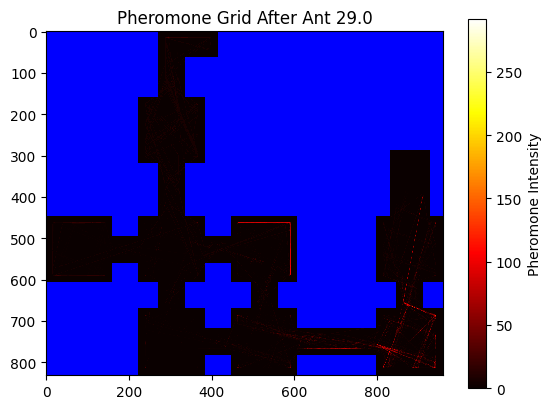

Ant 1 reached the goal in 820 steps.
Ant 29.1, tics: 820, success: True
Path: [(942, 812), (942, 813), (942, 814), (942, 815), (942, 815), (941, 815), (940, 815), (939, 815), (938, 815), (937, 815), (936, 815), (935, 815), (934, 815), (933, 815), (932, 815), (931, 815), (930, 815), (929, 815), (928, 815), (927, 815), (926, 815), (925, 815), (924, 815), (923, 815), (922, 815), (921, 815), (920, 815), (919, 815), (918, 815), (917, 815), (916, 815), (915, 815), (914, 815), (913, 815), (912, 815), (911, 815), (910, 815), (909, 815), (908, 815), (907, 815), (906, 815), (905, 815), (904, 815), (903, 815), (902, 815), (901, 815), (900, 815), (899, 815), (898, 815), (897, 815), (896, 815), (895, 815), (894, 815), (893, 815), (892, 815), (891, 815), (890, 815), (889, 815), (888, 815), (887, 815), (886, 815), (885, 815), (884, 815), (883, 815), (882, 815), (881, 815), (880, 815), (879, 815), (878, 815), (877, 815), (876, 815), (875, 815), (874, 815), (873, 815), (872, 815), (871, 815), (870, 815

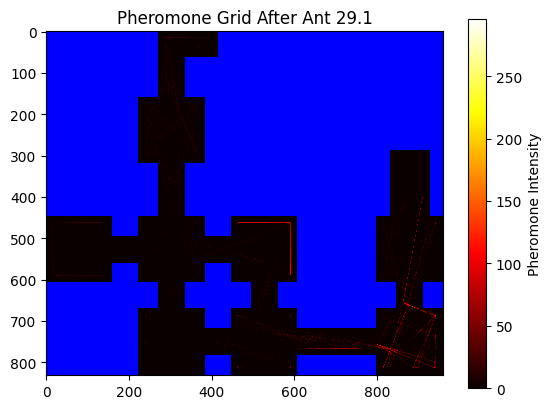

Ant 29.2, tics: 8425, success: False
Path: [(287, 647), (287, 646), (287, 645), (287, 644), (287, 643), (287, 642), (287, 641), (287, 640), (287, 639), (287, 638), (287, 637), (287, 636), (287, 635), (287, 634), (287, 633), (287, 632), (287, 631), (287, 630), (287, 629), (287, 628), (287, 627), (287, 626), (287, 625), (287, 624), (287, 623), (287, 622), (287, 621), (287, 620), (287, 619), (287, 618), (287, 617), (286, 616), (286, 615), (286, 614), (286, 613), (286, 612), (286, 611), (286, 610), (286, 609), (286, 608), (286, 607), (286, 606), (286, 605), (286, 604), (286, 603), (286, 602), (286, 601), (286, 600), (286, 599), (286, 598), (286, 597), (286, 596), (286, 595), (286, 594), (286, 593), (286, 592), (286, 591), (286, 590), (286, 589), (286, 588), (286, 587), (286, 586), (286, 585), (286, 584), (286, 583), (286, 582), (286, 581), (286, 580), (286, 579), (286, 578), (286, 577), (286, 576), (286, 575), (286, 574), (286, 573), (286, 572), (286, 571), (286, 570), (286, 569), (286, 56

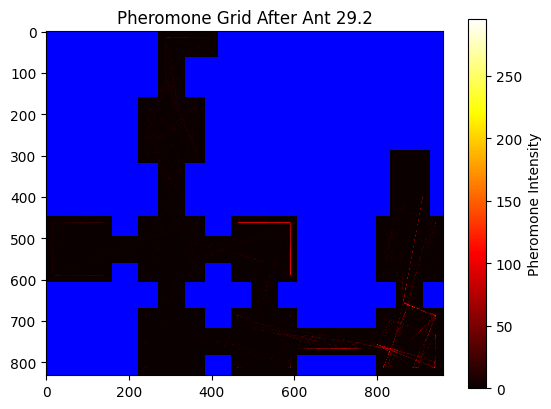

Ant 3 reached the goal in 1045 steps.
Ant 29.3, tics: 1045, success: True
Path: [(834, 814), (835, 814), (836, 814), (837, 814), (838, 814), (839, 814), (840, 814), (841, 814), (842, 814), (843, 814), (844, 814), (845, 814), (846, 814), (847, 814), (848, 814), (849, 814), (850, 814), (851, 814), (852, 814), (853, 814), (854, 814), (855, 814), (856, 814), (857, 814), (858, 814), (859, 814), (860, 814), (861, 814), (862, 814), (863, 814), (864, 814), (865, 814), (866, 814), (867, 814), (868, 814), (869, 814), (870, 814), (871, 814), (872, 814), (873, 814), (874, 814), (875, 814), (876, 814), (877, 814), (878, 814), (879, 814), (880, 814), (881, 814), (882, 814), (883, 814), (884, 814), (885, 814), (886, 814), (887, 815), (888, 815), (889, 815), (890, 815), (891, 815), (892, 815), (893, 815), (894, 815), (895, 815), (896, 815), (897, 815), (898, 815), (899, 815), (900, 815), (901, 815), (902, 815), (903, 815), (904, 815), (905, 815), (906, 815), (907, 815), (908, 815), (909, 815), (910, 8

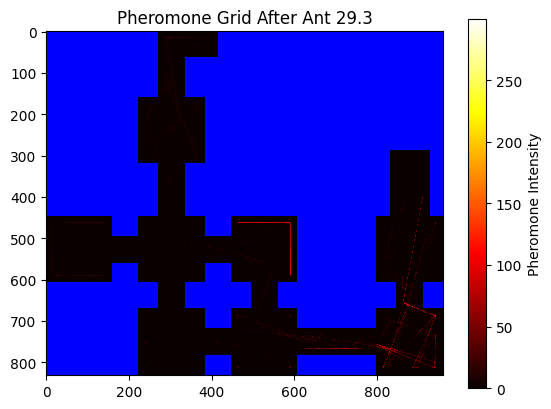

Ant 4 reached the goal in 1900 steps.
Ant 29.4, tics: 1900, success: True
Path: [(319, 82), (318, 83), (317, 83), (316, 84), (315, 84), (314, 85), (313, 86), (312, 86), (311, 87), (310, 87), (309, 88), (308, 89), (307, 89), (306, 90), (305, 90), (304, 91), (303, 92), (302, 92), (301, 93), (300, 93), (299, 94), (298, 94), (297, 95), (296, 96), (295, 96), (294, 97), (293, 97), (292, 98), (291, 99), (290, 99), (289, 100), (288, 100), (287, 101), (288, 100), (289, 100), (290, 99), (291, 99), (292, 98), (293, 97), (294, 97), (295, 96), (296, 96), (297, 95), (298, 94), (299, 94), (300, 93), (301, 93), (302, 92), (303, 92), (304, 91), (305, 90), (306, 90), (307, 89), (308, 89), (309, 88), (310, 87), (311, 87), (312, 86), (313, 86), (314, 85), (315, 84), (316, 84), (317, 83), (318, 83), (319, 82), (319, 81), (319, 80), (319, 79), (319, 78), (319, 77), (319, 76), (319, 75), (319, 74), (319, 73), (319, 72), (319, 71), (319, 70), (319, 69), (319, 68), (319, 67), (319, 66), (319, 65), (319, 64), (

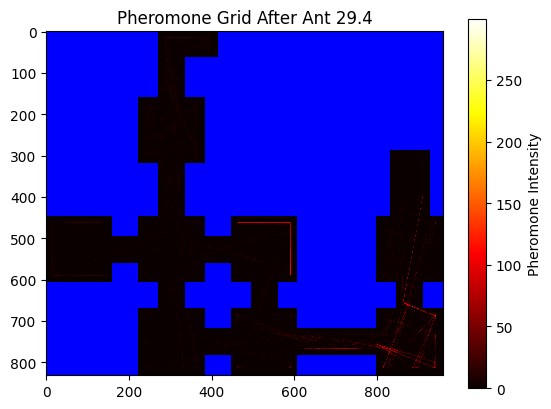

Ant 5 reached the goal in 2710 steps.
Ant 29.5, tics: 2710, success: True
Path: [(834, 814), (835, 814), (836, 814), (837, 814), (838, 814), (839, 814), (840, 814), (841, 814), (842, 814), (843, 814), (844, 814), (845, 814), (846, 814), (847, 814), (848, 814), (849, 814), (850, 814), (851, 814), (852, 814), (853, 814), (854, 814), (855, 814), (856, 814), (857, 814), (858, 814), (859, 814), (860, 814), (861, 814), (862, 814), (863, 814), (864, 814), (865, 814), (866, 814), (867, 814), (868, 814), (869, 814), (870, 814), (871, 814), (872, 814), (873, 814), (874, 814), (875, 814), (876, 814), (877, 814), (878, 814), (879, 814), (880, 814), (881, 814), (882, 814), (883, 814), (884, 814), (885, 814), (886, 814), (887, 815), (888, 815), (889, 815), (890, 815), (891, 815), (892, 815), (893, 815), (894, 815), (895, 815), (896, 815), (897, 815), (898, 815), (899, 815), (900, 815), (901, 815), (902, 815), (903, 815), (904, 815), (905, 815), (906, 815), (907, 815), (908, 815), (909, 815), (910, 8

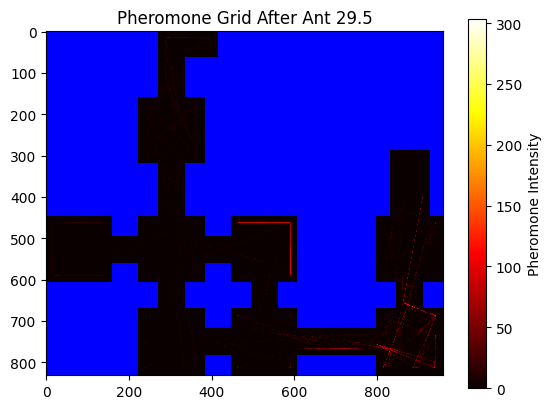

Ant 29.6, tics: 8425, success: False
Path: [(366, 303), (367, 303), (367, 303), (367, 303), (366, 303), (365, 304), (364, 304), (363, 305), (362, 305), (361, 306), (360, 306), (359, 306), (358, 307), (357, 307), (356, 308), (355, 308), (354, 309), (353, 309), (352, 309), (351, 310), (350, 310), (349, 311), (348, 311), (347, 312), (346, 312), (345, 312), (344, 313), (343, 313), (342, 314), (341, 314), (340, 314), (339, 315), (338, 315), (337, 316), (336, 316), (335, 317), (334, 317), (333, 317), (332, 318), (331, 318), (330, 319), (329, 319), (328, 320), (327, 320), (326, 320), (325, 321), (324, 321), (323, 322), (322, 322), (321, 323), (320, 323), (319, 323), (318, 324), (317, 324), (316, 325), (315, 325), (314, 326), (313, 326), (312, 326), (311, 327), (310, 327), (309, 328), (308, 328), (307, 328), (306, 329), (305, 329), (304, 330), (303, 330), (302, 331), (301, 331), (300, 331), (299, 332), (298, 332), (297, 333), (296, 333), (295, 334), (294, 334), (293, 334), (292, 335), (291, 33

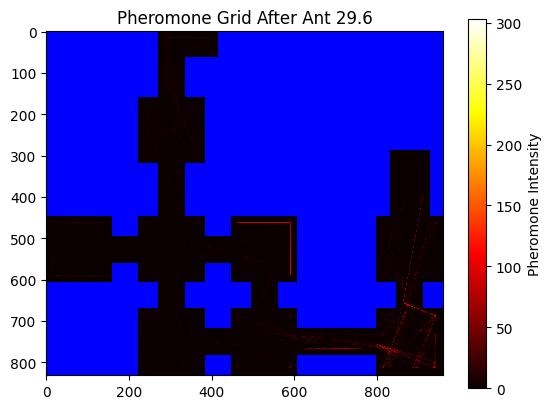

Ant 7 reached the goal in 235 steps.
Ant 29.7, tics: 235, success: True
Path: [(815, 476), (815, 477), (815, 478), (815, 479), (815, 480), (815, 481), (815, 482), (815, 483), (815, 484), (815, 485), (815, 486), (815, 487), (815, 488), (815, 489), (815, 490), (815, 491), (815, 492), (815, 493), (815, 494), (815, 495), (815, 496), (815, 497), (815, 498), (815, 499), (815, 500), (815, 501), (815, 502), (815, 503), (815, 504), (815, 505), (815, 506), (815, 507), (815, 508), (815, 509), (815, 510), (815, 511), (815, 512), (815, 513), (815, 514), (815, 515), (815, 516), (815, 517), (815, 518), (815, 519), (815, 520), (815, 521), (815, 522), (815, 523), (815, 524), (815, 525), (815, 526), (815, 527), (815, 528), (815, 529), (815, 530), (815, 531), (815, 532), (815, 533), (815, 534), (815, 535), (815, 536), (815, 537), (815, 538), (815, 539), (815, 540), (815, 541), (815, 542), (815, 543), (815, 544), (815, 545), (815, 546), (815, 547), (815, 548), (815, 549), (815, 550), (815, 551), (815, 552

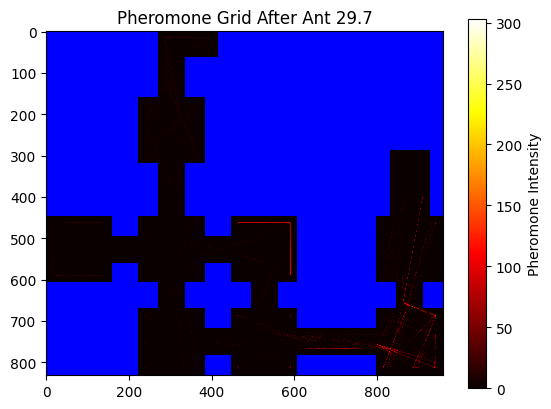

Ant 29.8, tics: 8425, success: False
Path: [(287, 656), (288, 656), (289, 655), (290, 655), (291, 655), (292, 654), (293, 654), (294, 654), (295, 653), (296, 653), (297, 653), (298, 652), (299, 652), (300, 652), (301, 651), (302, 651), (303, 650), (304, 650), (305, 650), (306, 649), (307, 649), (308, 649), (309, 648), (310, 648), (311, 648), (312, 647), (313, 647), (314, 647), (315, 646), (316, 646), (317, 646), (318, 645), (319, 645), (319, 644), (319, 643), (319, 642), (319, 641), (319, 640), (319, 639), (319, 638), (319, 637), (318, 636), (318, 635), (318, 634), (318, 633), (318, 632), (318, 631), (318, 630), (318, 629), (318, 628), (318, 627), (318, 626), (318, 625), (318, 624), (318, 623), (318, 622), (318, 621), (318, 620), (317, 619), (317, 618), (317, 617), (317, 616), (317, 615), (317, 614), (317, 613), (317, 612), (317, 611), (317, 610), (317, 609), (317, 608), (317, 607), (317, 606), (317, 605), (317, 604), (317, 603), (316, 602), (316, 601), (316, 600), (316, 599), (316, 59

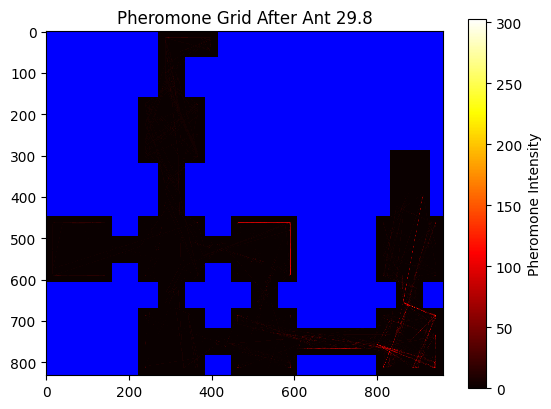

Ant 9 reached the goal in 685 steps.
Ant 29.9, tics: 685, success: True
Path: [(666, 735), (667, 735), (668, 735), (669, 736), (670, 736), (671, 736), (672, 736), (673, 736), (674, 737), (675, 737), (676, 737), (677, 737), (678, 737), (679, 738), (680, 738), (681, 738), (682, 738), (683, 738), (684, 739), (685, 739), (686, 739), (687, 739), (688, 739), (689, 740), (690, 740), (691, 740), (692, 740), (693, 740), (694, 741), (695, 741), (696, 741), (697, 741), (698, 741), (699, 742), (700, 742), (701, 742), (702, 742), (703, 742), (704, 743), (705, 743), (706, 743), (707, 743), (708, 743), (709, 744), (710, 744), (711, 744), (712, 744), (713, 744), (714, 745), (715, 745), (716, 745), (717, 745), (718, 745), (719, 746), (720, 746), (721, 746), (722, 746), (723, 746), (724, 747), (725, 747), (726, 747), (727, 747), (728, 747), (729, 748), (730, 748), (731, 748), (732, 748), (733, 748), (734, 749), (735, 749), (736, 749), (737, 749), (738, 749), (739, 750), (740, 750), (741, 750), (742, 750

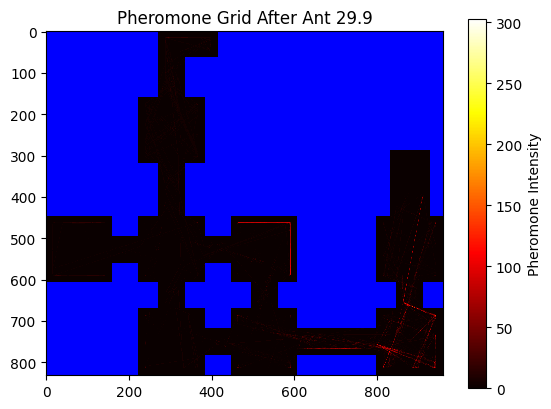

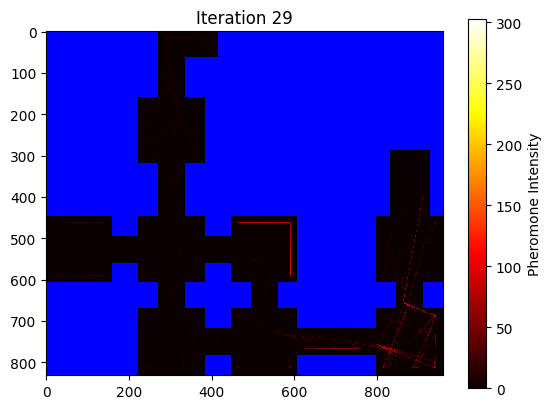

--------------------------------------------------
Spawn counts and success rates (for iteration 29):

Spawned far: 1/4
Spawned relatively close: 0/0
Spawned close: 6/6
Total spawn counts and success rates so far:
Total spawned far: 21/51
Total spawned relatively close: 23/62
Total spawned close: 117/187
--------------------------------------------------
Iteration 31/200
Ant 30.0, tics: 8425, success: False
Path: [(383, 595), (383, 594), (383, 593), (383, 592), (383, 591), (383, 590), (383, 589), (382, 588), (382, 587), (382, 586), (382, 585), (382, 584), (382, 583), (382, 582), (382, 581), (382, 580), (382, 579), (382, 578), (382, 577), (382, 576), (382, 575), (381, 574), (381, 573), (381, 572), (381, 571), (381, 570), (381, 569), (381, 568), (381, 567), (381, 566), (381, 565), (381, 564), (381, 563), (381, 562), (380, 561), (380, 560), (380, 559), (380, 558), (380, 557), (380, 556), (380, 555), (380, 554), (380, 553), (380, 552), (380, 551), (380, 550), (380, 549), (379, 548), (379, 

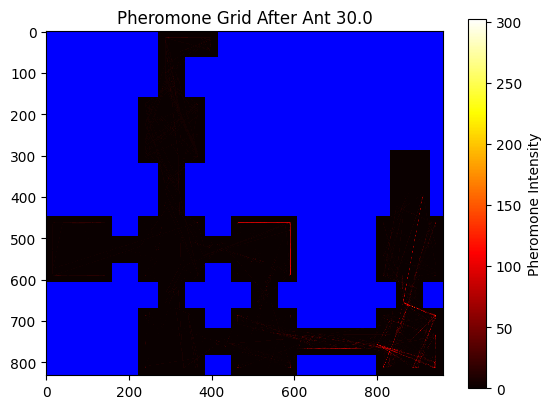

Ant 1 reached the goal in 7930 steps.
Ant 30.1, tics: 7930, success: True
Path: [(143, 590), (144, 589), (144, 588), (145, 587), (146, 586), (146, 585), (147, 584), (148, 583), (148, 582), (149, 581), (149, 580), (150, 579), (151, 578), (151, 577), (152, 576), (153, 575), (153, 574), (154, 573), (155, 572), (155, 571), (156, 570), (157, 569), (157, 568), (158, 567), (158, 566), (159, 565), (160, 564), (160, 563), (161, 562), (162, 561), (162, 560), (163, 559), (164, 558), (164, 557), (165, 556), (166, 555), (166, 554), (167, 553), (168, 552), (168, 551), (169, 550), (169, 549), (170, 548), (171, 547), (171, 546), (172, 545), (173, 544), (173, 543), (174, 542), (175, 541), (175, 540), (176, 539), (177, 538), (177, 537), (178, 536), (179, 535), (179, 534), (180, 533), (180, 532), (181, 531), (182, 530), (182, 529), (183, 528), (184, 527), (184, 526), (185, 525), (186, 524), (186, 523), (187, 522), (188, 521), (188, 520), (189, 519), (189, 518), (190, 517), (191, 516), (191, 515), (192, 5

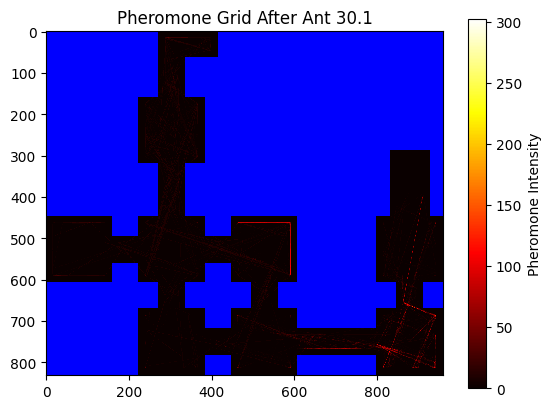

Ant 2 reached the goal in 6850 steps.
Ant 30.2, tics: 6850, success: True
Path: [(17, 463), (17, 463), (18, 463), (19, 463), (20, 463), (21, 463), (22, 463), (23, 463), (24, 463), (25, 463), (26, 463), (27, 463), (28, 463), (29, 463), (30, 463), (31, 463), (32, 463), (33, 463), (34, 463), (35, 463), (36, 463), (37, 463), (38, 463), (39, 463), (40, 463), (41, 463), (42, 463), (43, 463), (44, 463), (45, 463), (46, 463), (47, 463), (48, 463), (49, 463), (50, 463), (51, 463), (52, 463), (53, 463), (54, 463), (55, 463), (56, 463), (57, 463), (58, 463), (59, 463), (60, 463), (61, 463), (62, 463), (63, 463), (64, 463), (65, 463), (66, 463), (67, 463), (68, 463), (69, 463), (70, 463), (71, 463), (72, 463), (73, 463), (74, 463), (75, 463), (76, 463), (77, 463), (78, 463), (79, 463), (80, 463), (81, 463), (82, 463), (83, 463), (84, 463), (85, 463), (86, 463), (87, 463), (88, 463), (89, 463), (90, 463), (91, 463), (92, 463), (93, 463), (94, 463), (95, 463), (96, 463), (97, 463), (98, 463), (99, 4

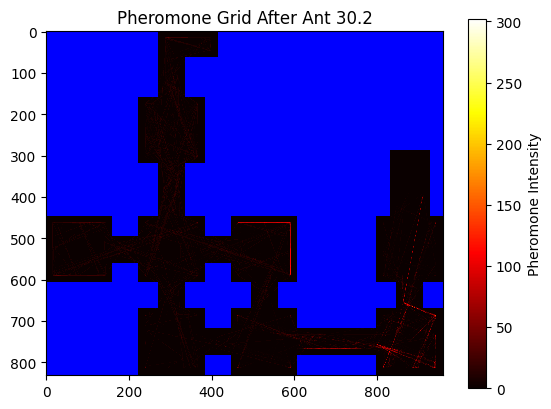

Ant 30.3, tics: 8425, success: False
Path: [(319, 452), (320, 452), (321, 453), (322, 453), (323, 453), (324, 454), (325, 454), (326, 454), (327, 454), (328, 455), (329, 455), (330, 455), (331, 456), (332, 456), (333, 456), (334, 457), (335, 457), (336, 457), (337, 458), (338, 458), (339, 458), (340, 459), (341, 459), (342, 459), (343, 460), (344, 460), (345, 460), (346, 460), (347, 461), (348, 461), (349, 461), (350, 462), (351, 462), (352, 462), (353, 463), (354, 463), (355, 463), (356, 464), (357, 464), (358, 464), (359, 464), (360, 465), (361, 465), (362, 465), (363, 466), (364, 466), (365, 466), (366, 467), (367, 467), (366, 467), (365, 467), (364, 468), (363, 468), (362, 468), (361, 468), (360, 468), (359, 469), (358, 469), (357, 469), (356, 469), (355, 469), (354, 470), (353, 470), (352, 470), (351, 470), (350, 470), (349, 471), (348, 471), (347, 471), (346, 471), (345, 471), (344, 472), (343, 472), (342, 472), (341, 472), (340, 472), (339, 473), (338, 473), (337, 473), (336, 47

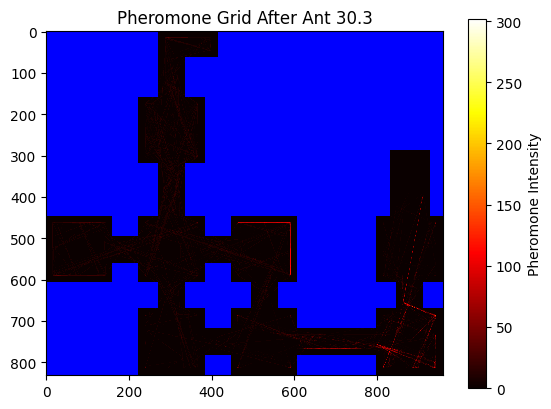

Ant 4 reached the goal in 550 steps.
Ant 30.4, tics: 550, success: True
Path: [(666, 735), (667, 735), (668, 735), (669, 736), (670, 736), (671, 736), (672, 736), (673, 736), (674, 737), (675, 737), (676, 737), (677, 737), (678, 737), (679, 738), (680, 738), (681, 738), (682, 738), (683, 738), (684, 739), (685, 739), (686, 739), (687, 739), (688, 739), (689, 740), (690, 740), (691, 740), (692, 740), (693, 740), (694, 741), (695, 741), (696, 741), (697, 741), (698, 741), (699, 742), (700, 742), (701, 742), (702, 742), (703, 742), (704, 743), (705, 743), (706, 743), (707, 743), (708, 743), (709, 744), (710, 744), (711, 744), (712, 744), (713, 744), (714, 745), (715, 745), (716, 745), (717, 745), (718, 745), (719, 746), (720, 746), (721, 746), (722, 746), (723, 746), (724, 747), (725, 747), (726, 747), (727, 747), (728, 747), (729, 748), (730, 748), (731, 748), (732, 748), (733, 748), (734, 749), (735, 749), (736, 749), (737, 749), (738, 749), (739, 750), (740, 750), (741, 750), (742, 750

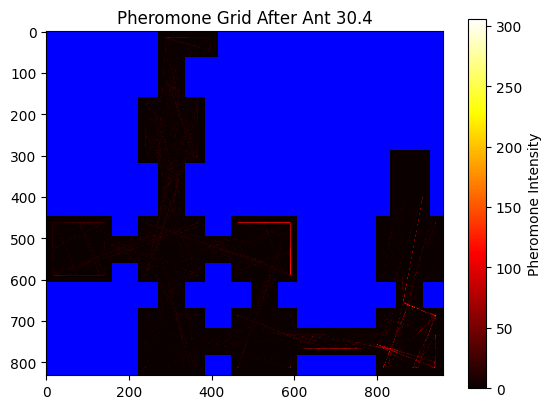

Ant 5 reached the goal in 5320 steps.
Ant 30.5, tics: 5320, success: True
Path: [(931, 687), (931, 688), (930, 689), (930, 690), (930, 691), (929, 692), (929, 693), (929, 694), (928, 695), (928, 696), (928, 697), (927, 698), (927, 699), (927, 700), (926, 701), (926, 702), (926, 703), (925, 704), (925, 705), (925, 706), (924, 707), (924, 708), (924, 709), (923, 710), (923, 711), (923, 712), (922, 713), (922, 714), (922, 715), (921, 716), (921, 717), (921, 718), (920, 719), (920, 720), (919, 721), (919, 722), (919, 723), (918, 724), (918, 725), (918, 726), (917, 727), (917, 728), (917, 729), (916, 730), (916, 731), (916, 732), (915, 733), (915, 734), (915, 735), (914, 736), (914, 737), (914, 738), (913, 739), (913, 740), (913, 741), (912, 742), (912, 743), (912, 744), (911, 745), (911, 746), (911, 747), (910, 748), (910, 749), (910, 750), (909, 751), (909, 752), (909, 753), (908, 754), (908, 755), (908, 756), (907, 757), (907, 758), (907, 759), (906, 760), (906, 761), (906, 762), (905, 7

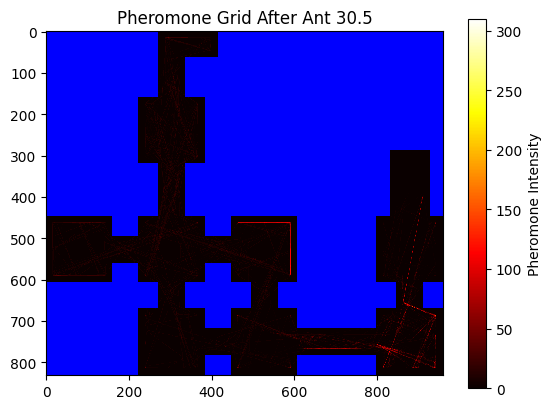

Ant 30.6, tics: 8425, success: False
Path: [(526, 463), (527, 463), (528, 463), (529, 463), (530, 463), (531, 463), (532, 463), (533, 463), (534, 463), (535, 463), (536, 463), (537, 463), (538, 463), (539, 463), (540, 463), (541, 463), (542, 463), (543, 463), (544, 463), (545, 463), (546, 463), (547, 463), (548, 463), (549, 463), (550, 463), (551, 463), (552, 463), (553, 463), (554, 463), (555, 463), (556, 463), (557, 463), (558, 463), (559, 463), (560, 463), (561, 463), (562, 463), (563, 463), (564, 463), (565, 463), (566, 463), (567, 463), (568, 463), (569, 463), (570, 463), (571, 463), (572, 463), (573, 463), (574, 463), (575, 463), (576, 463), (577, 463), (578, 463), (579, 463), (580, 463), (581, 463), (582, 463), (583, 463), (584, 463), (585, 463), (586, 463), (587, 463), (588, 463), (589, 463), (590, 463), (591, 463), (591, 463), (591, 464), (591, 465), (591, 466), (591, 467), (591, 468), (591, 469), (591, 470), (591, 471), (591, 472), (591, 473), (591, 474), (591, 475), (591, 47

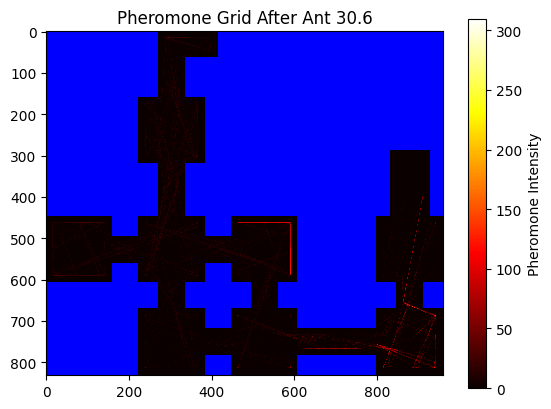

Ant 7 reached the goal in 2215 steps.
Ant 30.7, tics: 2215, success: True
Path: [(941, 814), (941, 813), (940, 812), (940, 811), (939, 810), (939, 809), (939, 808), (938, 807), (938, 806), (937, 805), (937, 804), (937, 803), (936, 802), (936, 801), (935, 800), (935, 799), (935, 798), (934, 797), (934, 796), (933, 795), (933, 794), (933, 793), (932, 792), (932, 791), (931, 790), (931, 789), (930, 788), (930, 787), (930, 786), (929, 785), (929, 784), (928, 783), (928, 782), (928, 781), (927, 780), (927, 779), (926, 778), (926, 777), (926, 776), (925, 775), (925, 774), (924, 773), (924, 772), (924, 771), (923, 770), (923, 769), (922, 768), (922, 767), (922, 766), (921, 765), (921, 764), (920, 763), (920, 762), (920, 761), (919, 760), (919, 759), (918, 758), (918, 757), (918, 756), (917, 755), (917, 754), (916, 753), (916, 752), (916, 751), (915, 750), (915, 749), (914, 748), (914, 747), (913, 746), (913, 745), (913, 744), (912, 743), (912, 742), (911, 741), (911, 740), (911, 739), (910, 7

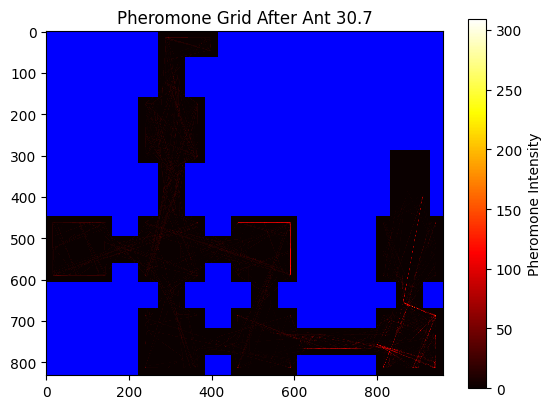

Ant 8 reached the goal in 3970 steps.
Ant 30.8, tics: 3970, success: True
Path: [(319, 126), (319, 127), (319, 128), (319, 129), (319, 130), (319, 131), (318, 132), (318, 133), (318, 134), (318, 135), (318, 136), (318, 137), (318, 138), (318, 139), (318, 140), (318, 141), (318, 142), (317, 143), (317, 144), (317, 145), (317, 146), (317, 147), (317, 148), (317, 149), (317, 150), (317, 151), (317, 152), (317, 153), (316, 154), (316, 155), (316, 156), (316, 157), (316, 158), (316, 159), (316, 160), (316, 161), (316, 162), (316, 163), (316, 164), (315, 165), (315, 166), (315, 167), (315, 168), (315, 169), (315, 170), (315, 171), (315, 172), (315, 173), (315, 174), (315, 175), (314, 176), (314, 177), (314, 178), (314, 179), (314, 180), (314, 181), (314, 182), (314, 183), (314, 184), (314, 185), (314, 186), (313, 187), (313, 188), (313, 189), (313, 190), (313, 191), (313, 192), (313, 193), (313, 194), (313, 195), (313, 196), (313, 197), (312, 198), (312, 199), (312, 200), (312, 201), (312, 2

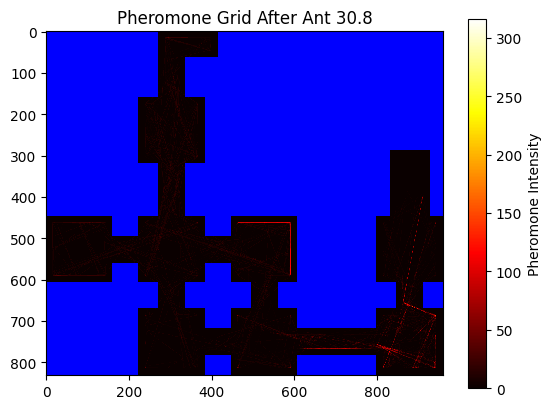

Ant 30.9, tics: 8425, success: False
Path: [(239, 463), (238, 464), (237, 465), (236, 466), (235, 467), (234, 467), (233, 468), (232, 469), (231, 470), (230, 471), (229, 472), (228, 473), (227, 474), (226, 475), (225, 476), (224, 476), (223, 477), (222, 478), (221, 479), (220, 480), (219, 481), (218, 482), (217, 483), (216, 484), (215, 485), (214, 485), (213, 486), (212, 487), (211, 488), (210, 489), (209, 490), (208, 491), (207, 492), (206, 493), (205, 494), (204, 494), (203, 495), (202, 496), (201, 497), (200, 498), (199, 499), (198, 500), (197, 501), (196, 502), (195, 503), (194, 503), (193, 504), (192, 505), (191, 506), (190, 507), (189, 508), (188, 509), (187, 510), (186, 511), (185, 512), (184, 512), (183, 513), (182, 514), (181, 515), (180, 516), (179, 517), (178, 518), (177, 519), (176, 520), (175, 521), (174, 521), (173, 522), (172, 523), (171, 524), (170, 525), (169, 526), (168, 527), (167, 528), (166, 529), (165, 530), (164, 530), (163, 531), (162, 532), (161, 533), (160, 53

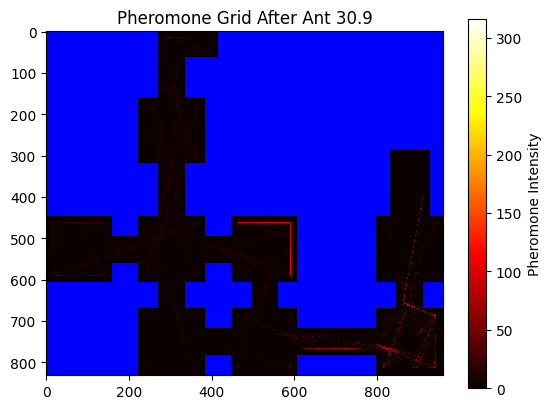

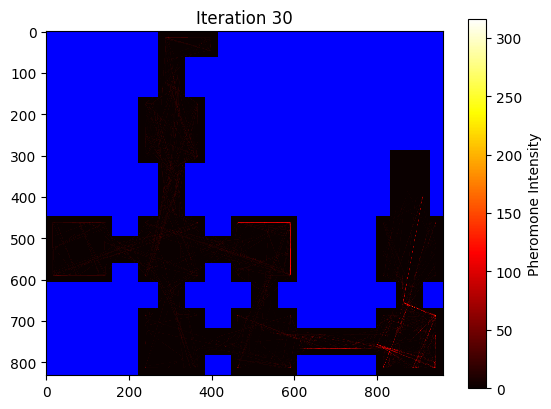

--------------------------------------------------
Spawn counts and success rates (for iteration 30):

Spawned far: 3/4
Spawned relatively close: 0/2
Spawned close: 3/4
Total spawn counts and success rates so far:
Total spawned far: 24/55
Total spawned relatively close: 23/64
Total spawned close: 120/191
--------------------------------------------------
Iteration 32/200
Ant 31.0, tics: 8425, success: False
Path: [(666, 735), (667, 735), (668, 735), (669, 736), (670, 736), (671, 736), (672, 736), (673, 736), (674, 737), (675, 737), (676, 737), (677, 737), (678, 737), (679, 738), (680, 738), (681, 738), (682, 738), (683, 738), (684, 739), (685, 739), (686, 739), (687, 739), (688, 739), (689, 740), (690, 740), (691, 740), (692, 740), (693, 740), (694, 741), (695, 741), (696, 741), (697, 741), (698, 741), (699, 742), (700, 742), (701, 742), (702, 742), (703, 742), (704, 743), (705, 743), (706, 743), (707, 743), (708, 743), (709, 744), (710, 744), (711, 744), (712, 744), (713, 744), (714, 

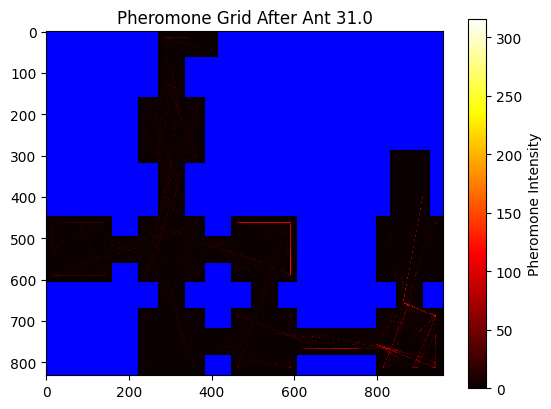

Ant 31.1, tics: 8425, success: False
Path: [(399, 16), (398, 16), (397, 16), (396, 16), (395, 16), (394, 16), (393, 16), (392, 16), (391, 16), (390, 16), (389, 16), (388, 16), (387, 16), (386, 16), (385, 16), (384, 16), (383, 16), (382, 16), (381, 16), (380, 16), (379, 16), (378, 16), (377, 16), (376, 16), (375, 16), (374, 16), (373, 16), (372, 16), (371, 16), (370, 16), (369, 16), (368, 16), (367, 16), (366, 16), (365, 16), (364, 16), (363, 16), (362, 16), (361, 16), (360, 16), (359, 16), (358, 16), (357, 16), (356, 16), (355, 16), (354, 16), (353, 16), (352, 16), (351, 16), (350, 16), (349, 16), (348, 16), (347, 16), (346, 16), (345, 16), (344, 16), (343, 16), (342, 15), (341, 15), (340, 15), (339, 15), (338, 15), (337, 15), (336, 15), (335, 15), (334, 15), (333, 15), (332, 15), (331, 15), (330, 15), (329, 15), (328, 15), (327, 15), (326, 15), (325, 15), (324, 15), (323, 15), (322, 15), (321, 15), (320, 15), (319, 15), (318, 15), (317, 15), (316, 15), (315, 15), (314, 15), (313, 15),

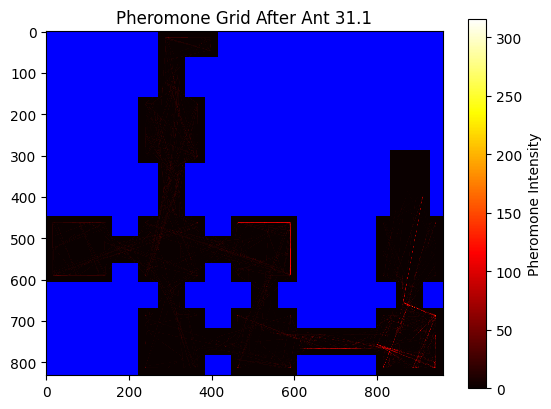

Ant 2 reached the goal in 2575 steps.
Ant 31.2, tics: 2575, success: True
Path: [(666, 735), (667, 735), (668, 735), (669, 735), (670, 735), (671, 735), (672, 735), (673, 735), (674, 735), (675, 735), (676, 735), (677, 735), (678, 735), (679, 735), (680, 735), (681, 735), (682, 735), (683, 735), (684, 735), (685, 735), (686, 735), (687, 735), (688, 735), (689, 735), (690, 735), (691, 735), (692, 735), (693, 735), (694, 735), (695, 735), (696, 735), (697, 735), (698, 735), (699, 735), (700, 735), (701, 735), (702, 735), (703, 735), (704, 735), (705, 735), (706, 735), (707, 735), (708, 735), (709, 735), (710, 735), (711, 735), (712, 735), (713, 735), (714, 735), (715, 735), (716, 735), (717, 735), (718, 735), (719, 735), (720, 735), (721, 735), (722, 735), (723, 735), (724, 735), (725, 735), (726, 735), (727, 735), (728, 735), (729, 735), (730, 735), (731, 735), (732, 735), (733, 735), (734, 735), (735, 735), (736, 735), (737, 735), (738, 735), (739, 735), (740, 735), (741, 735), (742, 7

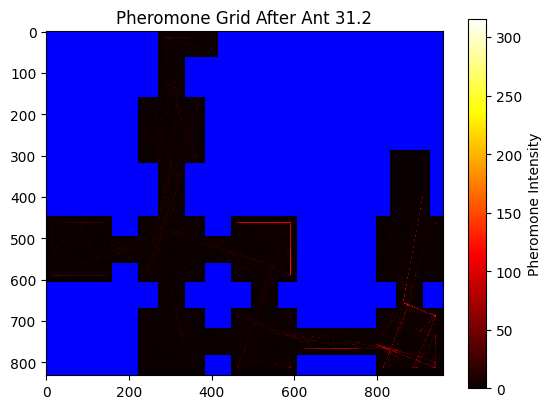

Ant 31.3, tics: 8425, success: False
Path: [(303, 436), (303, 435), (304, 434), (304, 433), (304, 432), (304, 431), (305, 430), (305, 429), (305, 428), (305, 427), (306, 426), (306, 425), (306, 424), (306, 423), (307, 422), (307, 421), (307, 420), (307, 419), (308, 418), (308, 417), (308, 416), (308, 415), (309, 414), (309, 413), (309, 412), (309, 411), (310, 410), (310, 409), (310, 408), (310, 407), (311, 406), (311, 405), (311, 404), (311, 403), (312, 402), (312, 401), (312, 400), (312, 399), (313, 398), (313, 397), (313, 396), (313, 395), (314, 394), (314, 393), (314, 392), (314, 391), (315, 390), (315, 389), (315, 388), (315, 387), (316, 386), (316, 385), (316, 384), (316, 383), (317, 382), (317, 381), (317, 380), (317, 379), (318, 378), (318, 377), (318, 376), (318, 375), (319, 374), (319, 373), (319, 166), (320, 167), (321, 168), (322, 169), (323, 170), (323, 171), (324, 172), (325, 173), (326, 174), (327, 175), (282, 14), (282, 15), (282, 16), (282, 17), (282, 18), (282, 19), (2

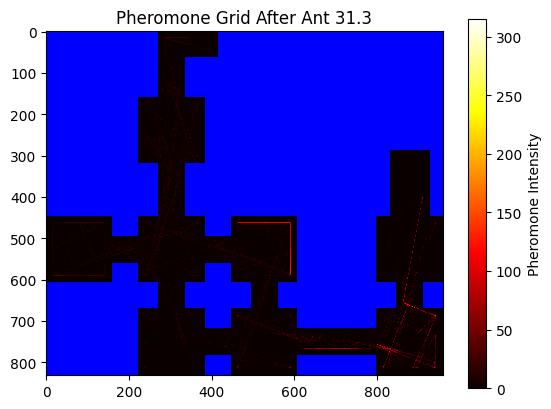

Ant 4 reached the goal in 2260 steps.
Ant 31.4, tics: 2260, success: True
Path: [(666, 735), (665, 735), (664, 735), (663, 734), (662, 734), (661, 734), (660, 734), (659, 734), (658, 734), (657, 733), (656, 733), (655, 733), (654, 733), (653, 733), (652, 732), (651, 732), (650, 732), (649, 732), (648, 732), (647, 732), (646, 731), (645, 731), (644, 731), (643, 731), (642, 731), (641, 730), (640, 730), (639, 730), (638, 730), (637, 730), (636, 730), (635, 729), (634, 729), (633, 729), (632, 729), (631, 729), (630, 728), (629, 728), (628, 728), (627, 728), (626, 728), (625, 728), (624, 727), (623, 727), (622, 727), (621, 727), (620, 727), (619, 726), (618, 726), (617, 726), (616, 726), (615, 726), (614, 726), (613, 725), (612, 725), (611, 725), (610, 725), (609, 725), (608, 724), (607, 724), (606, 724), (605, 724), (604, 724), (603, 724), (602, 723), (601, 723), (600, 723), (599, 723), (598, 723), (597, 722), (596, 722), (595, 722), (594, 722), (593, 722), (592, 722), (591, 721), (590, 7

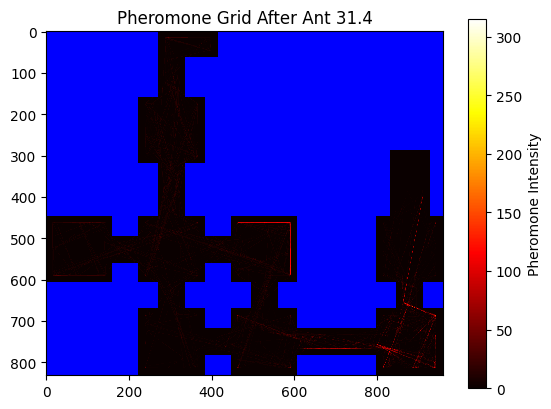

Ant 31.5, tics: 8425, success: False
Path: [(239, 297), (240, 298), (241, 299), (242, 299), (243, 300), (244, 301), (245, 302), (246, 303), (247, 304), (248, 304), (249, 305), (250, 306), (251, 307), (252, 308), (253, 309), (254, 309), (255, 310), (256, 311), (257, 312), (258, 313), (259, 314), (260, 314), (261, 315), (262, 316), (263, 317), (264, 318), (265, 318), (266, 319), (267, 320), (268, 321), (269, 322), (270, 323), (271, 323), (272, 324), (273, 325), (274, 326), (275, 327), (276, 328), (277, 328), (278, 329), (279, 330), (280, 331), (281, 332), (282, 332), (283, 333), (284, 334), (285, 335), (286, 336), (287, 337), (288, 337), (289, 338), (290, 339), (291, 340), (292, 341), (293, 342), (294, 342), (295, 343), (296, 344), (297, 345), (298, 346), (299, 346), (300, 347), (301, 348), (302, 349), (303, 350), (304, 351), (305, 351), (306, 352), (307, 353), (308, 354), (309, 355), (310, 356), (311, 356), (312, 357), (313, 358), (314, 359), (315, 360), (316, 361), (317, 361), (318, 36

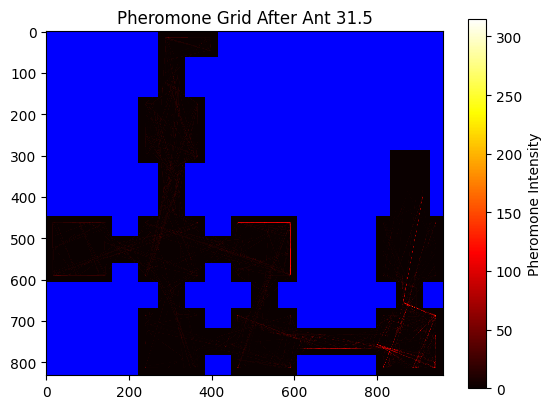

Ant 6 reached the goal in 685 steps.
Ant 31.6, tics: 685, success: True
Path: [(931, 687), (932, 687), (933, 687), (934, 687), (935, 687), (936, 687), (937, 687), (938, 687), (939, 687), (940, 687), (941, 687), (942, 687), (942, 688), (942, 689), (942, 690), (942, 691), (942, 692), (942, 693), (942, 694), (942, 695), (942, 696), (942, 697), (942, 698), (942, 699), (942, 700), (942, 701), (942, 702), (942, 703), (942, 704), (942, 705), (942, 706), (942, 707), (942, 708), (942, 709), (942, 710), (942, 711), (942, 712), (942, 713), (942, 714), (942, 715), (942, 716), (942, 717), (942, 718), (942, 719), (942, 720), (942, 721), (942, 722), (942, 723), (942, 724), (942, 725), (942, 726), (942, 727), (942, 728), (942, 729), (942, 730), (942, 731), (942, 732), (942, 733), (942, 734), (942, 735), (942, 736), (942, 737), (942, 738), (942, 739), (942, 740), (942, 741), (942, 742), (941, 743), (941, 744), (940, 745), (939, 746), (938, 747), (938, 748), (937, 749), (936, 750), (936, 751), (935, 752

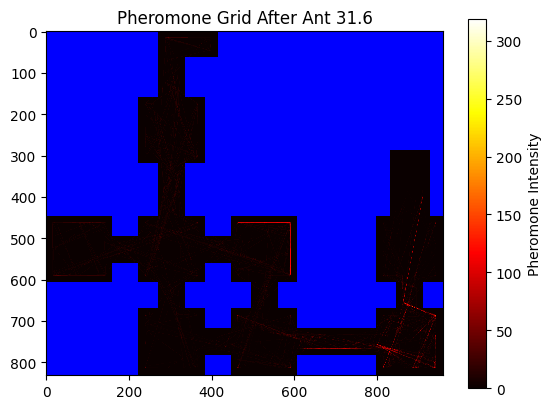

Ant 31.7, tics: 8425, success: False
Path: [(143, 463), (143, 463), (143, 463), (144, 464), (144, 465), (145, 466), (146, 467), (147, 468), (147, 469), (148, 470), (149, 471), (150, 472), (150, 473), (151, 474), (152, 475), (152, 476), (153, 477), (154, 478), (155, 479), (155, 480), (156, 481), (157, 482), (158, 483), (158, 484), (159, 485), (160, 486), (160, 487), (161, 488), (162, 489), (163, 490), (163, 491), (164, 492), (165, 493), (165, 494), (166, 495), (167, 496), (168, 497), (168, 498), (169, 499), (170, 500), (171, 501), (171, 502), (172, 503), (173, 504), (173, 505), (174, 506), (175, 507), (176, 508), (176, 509), (177, 510), (178, 511), (179, 512), (179, 513), (180, 514), (181, 515), (181, 516), (182, 517), (183, 518), (184, 519), (184, 520), (185, 521), (186, 522), (186, 523), (187, 524), (188, 525), (189, 526), (189, 527), (190, 528), (191, 529), (192, 530), (192, 531), (193, 532), (194, 533), (194, 534), (195, 535), (196, 536), (197, 537), (197, 538), (198, 539), (199, 54

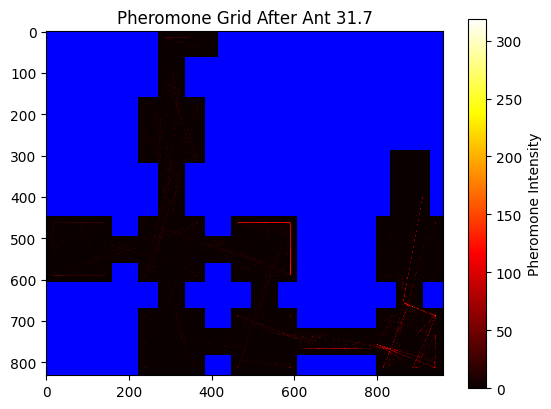

Ant 8 reached the goal in 2080 steps.
Ant 31.8, tics: 2080, success: True
Path: [(834, 814), (833, 814), (832, 814), (831, 814), (830, 814), (829, 814), (828, 814), (827, 814), (826, 814), (825, 814), (824, 814), (823, 814), (822, 814), (821, 814), (820, 814), (819, 814), (818, 814), (817, 814), (816, 814), (815, 814), (815, 814), (815, 813), (814, 812), (814, 811), (814, 810), (814, 809), (814, 808), (813, 807), (813, 806), (813, 805), (812, 804), (812, 803), (812, 802), (812, 801), (812, 800), (811, 799), (811, 798), (811, 797), (810, 796), (810, 795), (810, 794), (810, 793), (810, 792), (809, 791), (809, 790), (809, 789), (808, 788), (808, 787), (808, 786), (808, 785), (808, 784), (807, 783), (807, 782), (807, 781), (806, 780), (806, 779), (806, 778), (806, 777), (806, 776), (805, 775), (805, 774), (805, 773), (804, 772), (804, 771), (804, 770), (804, 769), (804, 768), (803, 767), (803, 766), (803, 765), (802, 764), (802, 763), (802, 762), (802, 761), (802, 760), (801, 759), (801, 7

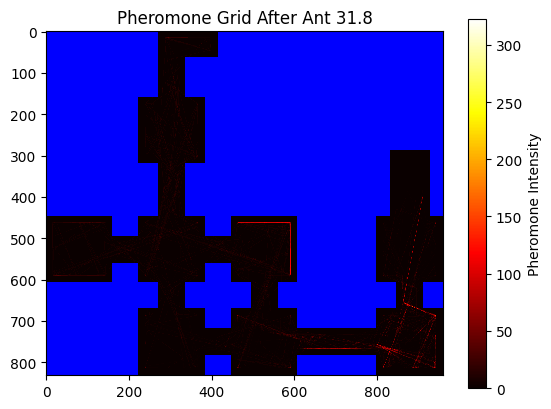

Ant 31.9, tics: 8425, success: False
Path: [(666, 735), (665, 735), (664, 735), (663, 734), (662, 734), (661, 734), (660, 734), (659, 734), (658, 734), (657, 733), (656, 733), (655, 733), (654, 733), (653, 733), (652, 732), (651, 732), (650, 732), (649, 732), (648, 732), (647, 732), (646, 731), (645, 731), (644, 731), (643, 731), (642, 731), (641, 730), (640, 730), (639, 730), (638, 730), (637, 730), (636, 730), (635, 729), (634, 729), (633, 729), (632, 729), (631, 729), (630, 728), (629, 728), (628, 728), (627, 728), (626, 728), (625, 728), (624, 727), (623, 727), (622, 727), (621, 727), (620, 727), (619, 726), (618, 726), (617, 726), (616, 726), (615, 726), (614, 726), (613, 725), (612, 725), (611, 725), (610, 725), (609, 725), (608, 724), (607, 724), (606, 724), (605, 724), (604, 724), (603, 724), (602, 723), (601, 723), (600, 723), (599, 723), (598, 723), (597, 722), (596, 722), (595, 722), (594, 722), (593, 722), (592, 722), (591, 721), (590, 721), (589, 721), (588, 721), (587, 72

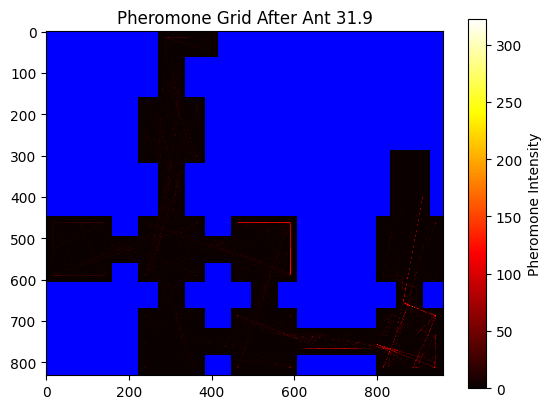

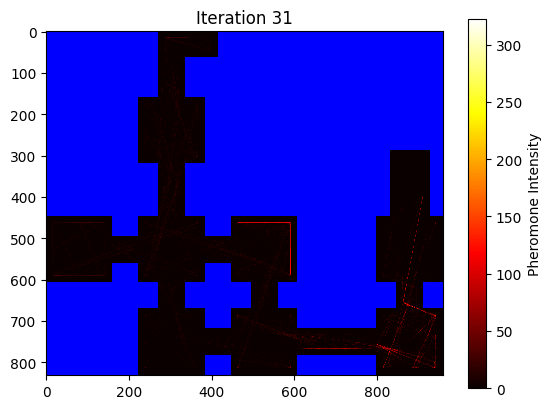

--------------------------------------------------
Spawn counts and success rates (for iteration 31):

Spawned far: 0/4
Spawned relatively close: 0/0
Spawned close: 4/6
Total spawn counts and success rates so far:
Total spawned far: 24/59
Total spawned relatively close: 23/64
Total spawned close: 124/197
--------------------------------------------------
Iteration 33/200
Ant 0 reached the goal in 1675 steps.
Ant 32.0, tics: 1675, success: True
Path: [(666, 735), (667, 735), (668, 735), (669, 736), (670, 736), (671, 736), (672, 736), (673, 736), (674, 737), (675, 737), (676, 737), (677, 737), (678, 737), (679, 738), (680, 738), (681, 738), (682, 738), (683, 738), (684, 739), (685, 739), (686, 739), (687, 739), (688, 739), (689, 740), (690, 740), (691, 740), (692, 740), (693, 740), (694, 741), (695, 741), (696, 741), (697, 741), (698, 741), (699, 742), (700, 742), (701, 742), (702, 742), (703, 742), (704, 743), (705, 743), (706, 743), (707, 743), (708, 743), (709, 744), (710, 744), (711,

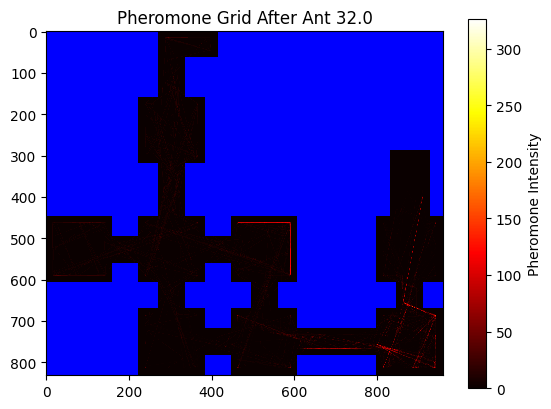

Ant 1 reached the goal in 1000 steps.
Ant 32.1, tics: 1000, success: True
Path: [(942, 812), (941, 812), (940, 812), (939, 812), (938, 812), (937, 812), (936, 812), (935, 812), (934, 812), (933, 812), (932, 812), (931, 812), (930, 812), (929, 812), (928, 813), (927, 813), (926, 813), (925, 813), (924, 813), (923, 813), (922, 813), (921, 813), (920, 813), (919, 813), (918, 813), (917, 813), (916, 813), (915, 813), (914, 813), (913, 813), (912, 813), (911, 813), (910, 813), (909, 813), (908, 813), (907, 813), (906, 813), (905, 813), (904, 813), (903, 813), (902, 814), (901, 814), (900, 814), (899, 814), (898, 814), (897, 814), (896, 814), (895, 814), (894, 814), (893, 814), (892, 814), (891, 814), (890, 814), (889, 814), (890, 814), (891, 814), (892, 814), (893, 814), (894, 814), (895, 814), (896, 814), (897, 814), (898, 814), (899, 814), (900, 814), (901, 814), (902, 814), (903, 814), (904, 814), (905, 814), (906, 814), (907, 814), (908, 814), (909, 814), (910, 814), (911, 814), (912, 8

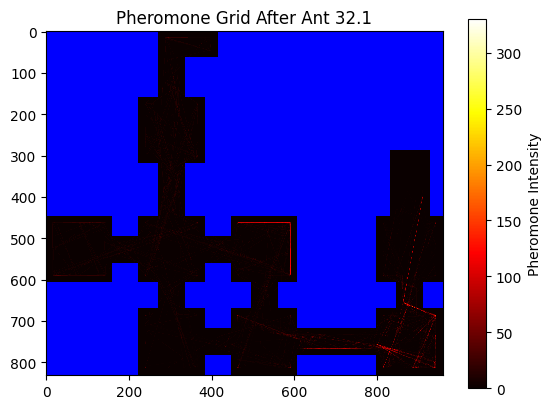

In [ ]:
#Initialize the environment and run ACO training

env = mywayhome_VZG(config_path=doomfinder("my_way_home_4_dir.cfg"), pheromone_evaporation_rate=0.2, render=False, frameskip=45) #Lower frameskip makes better maps but takes longer

#Create run directory
run_dir, log_dir, maps_dir = create_run_directory()

if saved_pheromone_grid is not None:
        env.pheromone_map = saved_pheromone_grid
else:
    env.pheromone_map = get_starting_grid()

aco_training(env, num_ants = 10, iterations=200, unsuccessful_deposit=0.1, pheromone_deposit = 20.0, run_dir=run_dir, log_dir=log_dir, maps_dir=maps_dir, alpha = 0.7, beta = 0.3, log_image_rate = 25) #Run ACO training


Test Pheromone Map

In [ ]:
#Initialize the environment for testing
env = mywayhome_VZG(config_path=doomfinder("my_way_home_4_dir.cfg"), pheromone_evaporation_rate=0, render=True, frameskip=45) 

#Run the test function
test_saved_maps(env=env, num_tests=5, pheromone_grid=saved_pheromone_grid, alpha = 0.7, beta = 0.3) #Test the saved pheromone maps

Test Movement, making a function to predict acceleration 

In [ ]:
frameskip = 1

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#Define the functions to fit the curve to

def exponential_decay(x, a, b):
    return a * (1 - np.exp(-b * x))

def tanh(x, a, b, c):
    return a * np.tanh(b * (x - c))

def log_func(x, a, b):
    return a * np.log(x) + b

function_map = {
    "Exponential Decay": (exponential_decay, ["a", "b"]),
    #"Logarithmic": (log_func, ["a", "b"]),
    #"Hyperbolic Tangent": (tanh, ["a", "b", "c"]),
}

def graph(steps, velocities, color, motion, fit_type):
    """
    Fit a curve to the data and plot the results.

    Args:
        steps (list): List of steps.
        velocities (list): List of velocities.
        color (str): Color for the data points.
        motion (str): Description of the motion.
        fit_type (str): Type of curve to fit.
    """
    
    #Convert to np arrays
    steps = np.array(steps) 
    velocities = np.array(velocities)

    #Select the fitting function
    func, param_names = function_map[fit_type]

    #Fit the curve
    try:
        popt, pcov = curve_fit(func, steps, velocities)
    except Exception as e:
        print(f"Failed to fit {fit_type}: {e}")
        return

    #Extract parameters
    params = ", ".join(f"{name}={val:.3f}" for name, val in zip(param_names, popt))

    #Generate points for the fitted curve
    x_fit = np.linspace(min(steps), max(steps), 1000)
    y_fit = func(x_fit, *popt)

    #Print the parameters
    print(f"Fitted parameters ({fit_type}/{motion}): {params}")

    #Plot the data and the fit
    plt.scatter(steps, velocities, label="Data", color=color)
    plt.plot(x_fit, y_fit, label=f"Fit: {fit_type} ({params})", color="red")
    plt.xlabel("Steps")
    plt.ylabel("Velocity")
    plt.legend()
    plt.title(f"Doom Acceleration {fit_type} Fit - {motion}")
    plt.grid()
    plt.show()


#Initialize the environment for testing
env = mywayhome_VZG(config_path=doomfinder("movement_test.cfg"), pheromone_evaporation_rate=0, render=False, frameskip=frameskip) 

#Data collection
actions = [0, 1, 2, 3]
colors = ["blue", "orange", "green", "purple"]
titles = ["Moving Forward", "Moving Left", "Moving Right", "Moving Backward"]

for fit_type in function_map.keys():
    for action in actions:
        steps = []
        velocities = []
        color = colors[action]
        motion = titles[action]
        for i in range(1, 201):
            env.step(action = action)
            #time.sleep(0.9)
            steps.append(i)
            if action == 0 or action == 3:
                velocities.append(env.velocity_y)
            else:
                velocities.append(env.velocity_x)

            #print(f"step {i}, x velocity = {env.velocity_x}, y velocity = {env.velocity_y})")
        env.reset()

        graph(steps, velocities, color, motion, fit_type)

#Exponential decay seems to fit best

The issue is that this assumes the agent goes to a fullstop before changing directions, we can't assume this, but we compare with a simple friction function, and find that it matches down down to a tolerance of 1-e3. This is very close.

The reason we need to know this is that we need to predict movement of the agent for decision making, but due to frameskip, we don't always know the velocity, so we have to adjust it overtime. 

In [ ]:
def compare(a, b, steps, velocities, title):
    """
    Compare the exponential decay model and adjusted friction model to velocity data.

    Args:
        a (float): The exponential decay function approaches this value (asymptote).
        b (float): The rate at which the function approaches a.
        steps (array-like): The steps (time points) for the observed data.
        velocities (array-like): The observed velocity data points.
        title (str): The title for the motion being analyzed.
    """

    friction = 0.90625  #DOOM friction

    #Our friction floor/ceiling values should be the same as our exponential decay floor/ceiling values
    v_ceiling = abs(a) #Must be positive, defined by the exponential decay function ceiling/floor
    v_floor = 0 #Friction decays to zero

    v0 = v_ceiling #Initial velocity, will decay to 0 as exponential decay function reaches a

    #Time steps for friction model
    time_steps = np.arange(0, 200, 1)

    #Adjusted friction-based velocity model with floor and ceiling
    friction_velocities_adjusted = [v0]
    for t in time_steps[1:]:
        v_prev = friction_velocities_adjusted[-1]
        if v_prev > v_floor:  #Decaying toward floor
            v_next = v_floor + (v_prev - v_floor) * friction
        elif v_prev < v_ceiling:  #Decaying toward ceiling
            v_next = v_ceiling + (v_prev - v_ceiling) * friction
        friction_velocities_adjusted.append(v_next)

    #Exponential decay model
    exp_decay_velocities = a * (1 - np.exp(-b * time_steps))

    #Determine when friction approaches zero
    tolerance = 1e-3
    friction_zero_time = next((t for t, v in enumerate(friction_velocities_adjusted) if np.isclose(v, v_floor, atol=tolerance)), None)

    #Determine when exponential decay approaches a
    decay_target_velocity = a
    decay_target_time = next((t for t, v in enumerate(exp_decay_velocities) if np.isclose(v, decay_target_velocity, atol=tolerance)), None)

    #Plot observed data
    plt.scatter(steps, velocities, label="Observed Data", color="purple", alpha=0.7)

    #Add vertical lines for the two events
    if friction_zero_time is not None:
        plt.axvline(friction_zero_time, color="blue", linestyle=":", label=f"Friction hits 0 (t={friction_zero_time})", alpha=0.7)
    if decay_target_time is not None:
        plt.axvline(decay_target_time, color="red", linestyle=":", label=f"Decay hits a (t={decay_target_time})", alpha=0.7)

    #Plot both models
    plt.plot(time_steps, friction_velocities_adjusted, label="Adjusted Friction Model (Floor & Ceiling)", color="blue")
    plt.plot(time_steps, exp_decay_velocities, label="Exponential Decay Model", color="red", linestyle="--")

    #Add labels, legend, and grid
    plt.xlabel("Time Steps")
    plt.ylabel("Velocity")
    plt.title(f"Comparison for {title}")
    plt.legend()
    plt.grid()
    plt.show()

#Initialize the environment for testing
env = mywayhome_VZG(config_path=doomfinder("movement_test.cfg"), pheromone_evaporation_rate=0, render=False, frameskip=1) 

#Data collection
step_sets = []
velocity_sets = []

for fit_type in function_map.keys():
    for action in actions:
        steps = []
        velocities = []
        color = colors[action]
        motion = titles[action]
        for i in range(1, 201):
            env.step(action=action)
            steps.append(i)
            if action == 0 or action == 3:
                velocities.append(env.velocity_y)
            else:
                velocities.append(env.velocity_x)
        env.reset()
        step_sets.append(np.array(steps))
        velocity_sets.append(np.array(velocities))

#Comparing models using collected data
params = ((-7.552, 0.098), (7.250, 0.098), (-7.250, 0.098), (7.552, 0.098))  #Exponential decay parameters

for param, steps, velocities, title in zip(params, step_sets, velocity_sets, titles):
    print(f"Model for {title}: {param}")
    compare(*param, steps, velocities, title)

Trying to get the graphs to match

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compare(a, b, steps, velocities, title, action):
    """
    Compare the exponential decay model and adjusted friction model to velocity data.

    Args:
        a (float): The exponential decay function approaches this value (asymptote).
        b (float): The rate at which the function approaches a.
        steps (array-like): The steps (time points) for the observed data.
        velocities (array-like): The observed velocity data points.
        title (str): The title for the motion being analyzed.
        action (int): What direction we are moving in.
    """

    friction = 0.90625  #DOOM friction

    #Our friction floor/ceiling values should be the same as our exponential decay floor/ceiling values
    v_ceiling = abs(a) #Must be positive, defined by the exponential decay function ceiling/floor
    v_floor = -1 * v_ceiling #Friction decays to the negative of the asymptote if it's not already negative

    v0 = 0 #Initial velocity

    #Time steps for friction model
    time_steps = np.arange(0, 200, 1)

    #Adjusted friction-based velocity model with floor and ceiling
    friction_velocities_adjusted = [v0]
    for t in time_steps[1:]:
        v_prev = friction_velocities_adjusted[-1]
        if action in [0, 2]:  #Decaying toward floor for actions 0 and 2
            v_next = v_floor + (v_prev - v_floor) * friction
        else:  #Decaying toward ceiling for actions 1 and 3
            v_next = v_ceiling + (v_prev - v_ceiling) * friction
        friction_velocities_adjusted.append(v_next)

    #Exponential decay model
    exp_decay_velocities = a * (1 - np.exp(-b * time_steps))

    #Determine when friction approaches the target value
    tolerance = 1e-3
    if action in [0, 2]:
        friction_target_time = next((t for t, v in enumerate(friction_velocities_adjusted) if np.isclose(v, v_floor, atol=tolerance)), None)
    else:
        friction_target_time = next((t for t, v in enumerate(friction_velocities_adjusted) if np.isclose(v, v_ceiling, atol=tolerance)), None)

    #Determine when exponential decay approaches a
    decay_target_velocity = a
    decay_target_time = next((t for t, v in enumerate(exp_decay_velocities) if np.isclose(v, decay_target_velocity, atol=tolerance)), None)

    #Plot observed data
    plt.scatter(steps, velocities, label="Observed Data", color="purple", alpha=0.7)

    #Add vertical lines for the two events
    if friction_target_time is not None:
        plt.axvline(friction_target_time, color="blue", linestyle=":", label=f"Friction hits target (t={friction_target_time})", alpha=0.7)
    if decay_target_time is not None:
        plt.axvline(decay_target_time, color="red", linestyle=":", label=f"Decay hits target (t={decay_target_time})", alpha=0.7)

    #Plot both models
    plt.plot(time_steps, friction_velocities_adjusted, label="Adjusted Friction Model (Floor & Ceiling)", color="blue")
    plt.plot(time_steps, exp_decay_velocities, label="Exponential Decay Model", color="red", linestyle="--")

    #Add labels, legend, and grid
    plt.xlabel("Time Steps")
    plt.ylabel("Velocity")
    plt.title(f"Comparison for {title}")
    plt.legend()
    plt.grid()
    plt.show()

#Initialize the environment for testing
env = mywayhome_VZG(config_path=doomfinder("movement_test.cfg"), pheromone_evaporation_rate=0, render=False, frameskip=1) 

#Data collection
step_sets = []
velocity_sets = []

for fit_type in function_map.keys():
    for action in actions:
        steps = []
        velocities = []
        color = colors[action]
        motion = titles[action]
        for i in range(1, 201):
            env.step(action=action)
            steps.append(i)
            if action == 0 or action == 3:
                velocities.append(env.velocity_y)
            else:
                velocities.append(env.velocity_x)
        env.reset()
        step_sets.append(np.array(steps))
        velocity_sets.append(np.array(velocities))

#Comparing models using collected data
params = ((-7.552, 0.098), (7.250, 0.098), (-7.250, 0.098), (7.552, 0.098))  #Exponential decay parameters

for param, steps, velocities, title, action in zip(params, step_sets, velocity_sets, titles, actions):
    print(f"Model for {title}: {param}")
    compare(*param, steps, velocities, title, action)